<center><h1>Bank Marketing: Identify Potential Cleints - Classification Modeling</h1></center>

# Introduction

Marketing campaigns are characterized by focusing on the customer needs and their overall satisfaction. Nevertheless, there are different variables that determine whether a marketing campaign will be successful or not. There are certain variables that we need to take into consideration when making a marketing campaign.

The goal of this notebook is to use the data to develop a strong model in order to predict which people the bank should market to for their marketing campain to get people to sign up for a term deposit.

# About the data

Unfortunately, not much about the data is given besides for the below information. More information about where this data came from can be found at this website: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing#

## Bank client data:<br>
1 - **age:** (numeric)<br>
2 - **job:** type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')<br>
3 - **marital:** marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)<br>
4 - **education:** (categorical: primary, secondary, tertiary and unknown)<br>
5 - **default:** has credit in default? (categorical: 'no','yes','unknown')<br>
6 - **housing:** has housing loan? (categorical: 'no','yes','unknown')<br>
7 - **loan:** has personal loan? (categorical: 'no','yes','unknown')<br>
8 - **balance:** Balance of the individual.

## Related with the last contact of the current campaign:
8 - **contact:** contact communication type (categorical: 'cellular','telephone') <br>
9 - **month:** last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')<br>
10 - **day:** last contact day of the week (categorical: 'mon','tue','wed','thu','fri')<br>
11 - **duration:** last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.<br>
## Other attributes:<br>
12 - **campaign:** number of contacts performed during this campaign and for this client (numeric, includes last contact)<br>
13 - **pdays:** number of days that passed by after the client was last contacted from a previous campaign (numeric; -1 means client was not previously contacted)<br>
14 - **previous:** number of contacts performed before this campaign and for this client (numeric)<br>
15 - **poutcome:** outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')<br>

Output variable (desired target):<br>
16 - **deposit** - has the client subscribed a term deposit? (binary: 'yes','no')

# Libraries

## Libraries for plotting and analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib import pyplot
from numpy import where
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## Libraries for Modeling

In [34]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from lightgbm import LGBMClassifier
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

## Data Exploration

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
%cd /gdrive/My Drive

/gdrive/My Drive


In [6]:
# data = pd.read_csv('bank.csv', sep=';')
data = pd.read_csv('bank-full.csv', sep=',')
data.head()

age           job  marital  education  ... pdays  previous poutcome Target
0   58    management  married   tertiary  ...    -1         0  unknown     no
1   44    technician   single  secondary  ...    -1         0  unknown     no
2   33  entrepreneur  married  secondary  ...    -1         0  unknown     no
3   47   blue-collar  married    unknown  ...    -1         0  unknown     no
4   33       unknown   single    unknown  ...    -1         0  unknown     no

[5 rows x 17 columns]

In [7]:
data.shape

(45211, 17)

In [8]:
#check for any Null values
nulls = []
for i in data.columns:
    nulls.append(data[i].isnull().sum())
print(nulls)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [9]:
#check the column data types
types=[]
for i in data.columns:
    types.append(type(data[i][0]))
print(types)

[<class 'numpy.int64'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'numpy.int64'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'numpy.int64'>, <class 'str'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'str'>, <class 'str'>]


In [10]:
data.rename(columns = {'Target': 'y'}, inplace = True)

In [11]:
cat_cols = np.array(['job', 'marital', 'education', 'default', 'housing', 'loan', 
                     'contact', 'month', 'poutcome', 'y'])
for x in cat_cols:
    print("Attribute \"%s\":" % (x), data[x].unique())

Attribute "job": ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
Attribute "marital": ['married' 'single' 'divorced']
Attribute "education": ['tertiary' 'secondary' 'unknown' 'primary']
Attribute "default": ['no' 'yes']
Attribute "housing": ['yes' 'no']
Attribute "loan": ['no' 'yes']
Attribute "contact": ['unknown' 'cellular' 'telephone']
Attribute "month": ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
Attribute "poutcome": ['unknown' 'failure' 'other' 'success']
Attribute "y": ['no' 'yes']


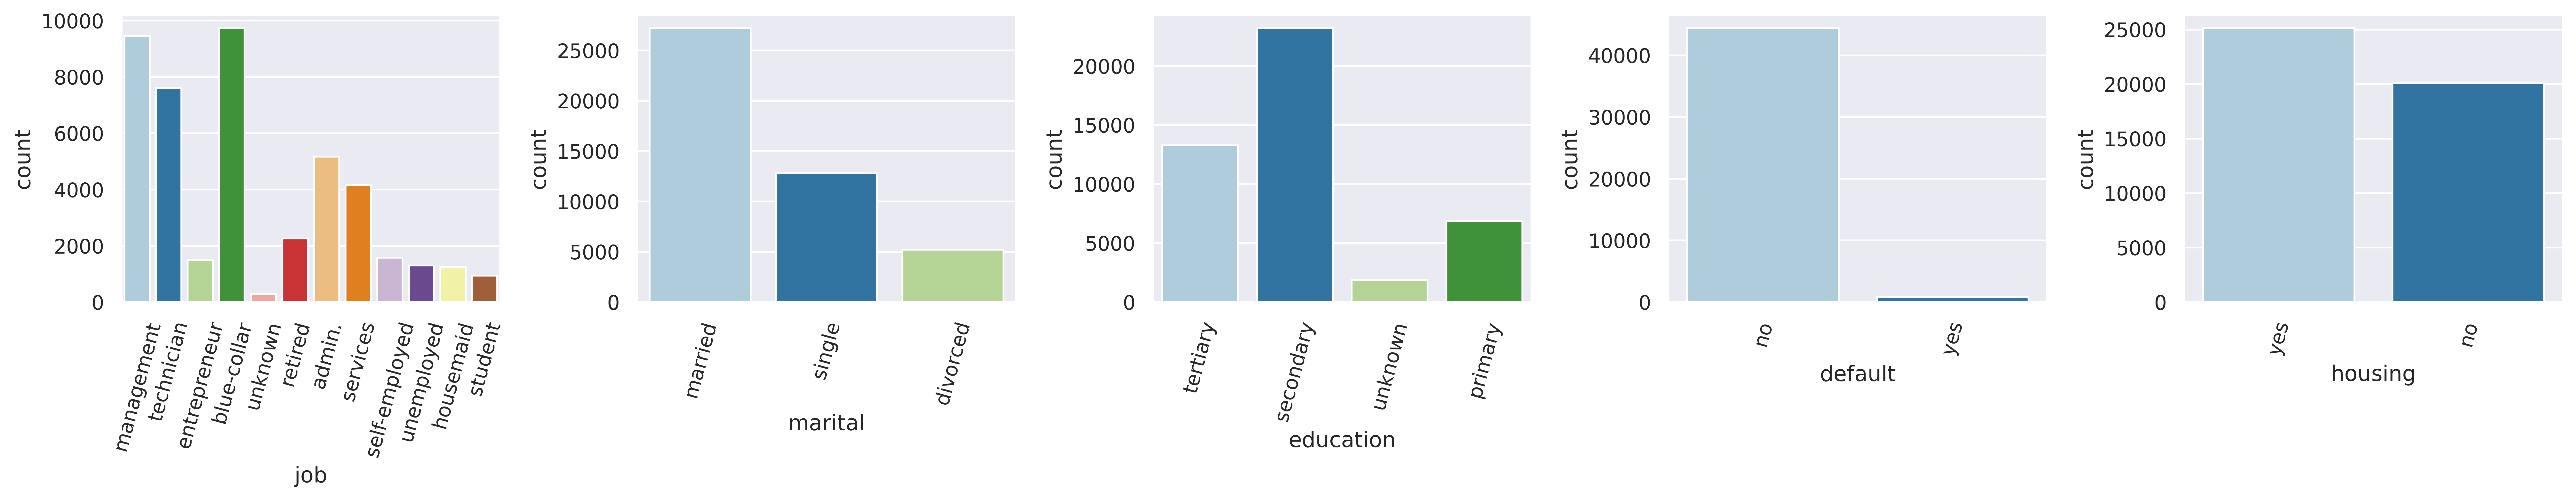

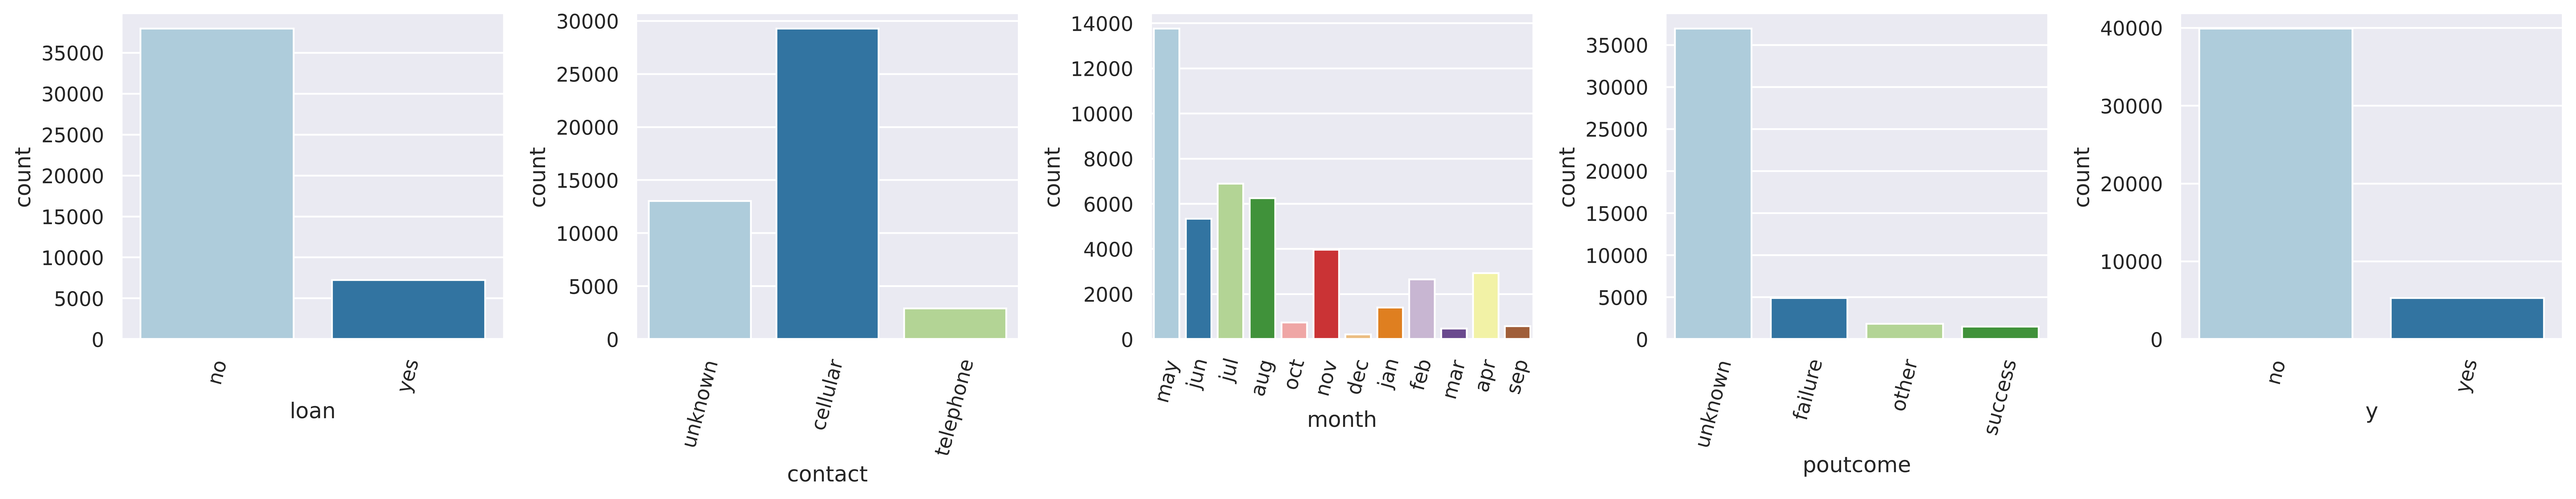

In [12]:
# Plot the distribbution of categorical attributes
def chunks(l, n):
    return [l[i:i + n] for i in range(0, len(l), n)]

def histplot(df, cols, ncols):
    for lst in chunks(cols, ncols):
        sns.set(font_scale = 1)
        fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(20, 4), dpi=600)
        for idx in range(0, len(lst)):
            attr = lst[idx]
            data = df[attr]
            sns.set_palette('Paired',30)
            g = sns.countplot(x=attr, data=df, ax=axes[idx])
            for item in g.get_xticklabels():
                item.set_rotation(75)
        plt.tight_layout()

histplot(data[cat_cols], cat_cols, 5)

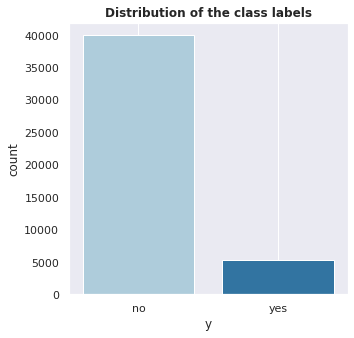

In [13]:
plt.figure(figsize=(5, 5))
sns.countplot(data['y']) 
plt.grid() 
plt.title("Distribution of the class labels", weight="semibold") 
plt.show()

# Data Cleaning: Numeric Variables

Let's start by cleaning the numeric variables and viewing the basic statistics. 

In [14]:
data.describe()

age        balance  ...         pdays      previous
count  45211.000000   45211.000000  ...  45211.000000  45211.000000
mean      40.936210    1362.272058  ...     40.197828      0.580323
std       10.618762    3044.765829  ...    100.128746      2.303441
min       18.000000   -8019.000000  ...     -1.000000      0.000000
25%       33.000000      72.000000  ...     -1.000000      0.000000
50%       39.000000     448.000000  ...     -1.000000      0.000000
75%       48.000000    1428.000000  ...     -1.000000      0.000000
max       95.000000  102127.000000  ...    871.000000    275.000000

[8 rows x 7 columns]

Before moving on we will remove "duration" from our dataset because of target leakage, or the idea that the field gives information into the future. To put it in another way, this is information that we should not have yet. As noted above this field highly affects the output because if a person had a phone call duration of 0, we can assume the caller didn't pick up the phone and therefore had no chance of a sale.

In [15]:
data.pop("duration")

0         261
1         151
2          76
3          92
4         198
         ... 
45206     977
45207     456
45208    1127
45209     508
45210     361
Name: duration, Length: 45211, dtype: int64

Becase "day represents the day of the week we should really treat this as a catigorical variable and not a numeric. Additionally, we will combine these values into 3 buckets: beginning of the month, middle of the month, and end of the month. This will prevent us from having 31 different one-hot encoded variables and generalize the variable so that it makes sense to the business problem at hand. After transforming "day" into a catigorical variable we will one-hot encode it with the other categoriccal variables.

In [16]:
#start = beginning of the month
#middle = middle of the month
#end = end of the month

temp_day = []
for i in data['day']:
    if i<10:
        temp_day.append("start")
    elif i>20:
        temp_day.append("end")
    else:
        temp_day.append("middle")

data['day'] = temp_day

The variable "pdays" represents the number of days that passed by after the client was last contacted from a previous campaign. We need to also note that if the client was never contacted the value of this field is -1. Becuase a value of -1 doesn't make sense in this field and won't properly capture that a client wasn't contacted I would normally create a new binary variable but "poutcome" = nonexistant captures this for us.

Below are some interesting insights we can find from the data:

In [17]:
neg_bal = float(len(data['balance'][data['balance']<0]))/float(len(data['balance']))
print("{:.2%}".format(neg_bal)+ " percent of people or "+str(int(neg_bal*11162))+ " people have a negative balance");

8.33% percent of people or 929 people have a negative balance


In [18]:
first_contact = float(len(data['pdays'][data['pdays']==-1]))/float(len(data['pdays']))
print("Percentage of people that is being contacted for the first time: "+"{:.2%}".format(first_contact));

Percentage of people that is being contacted for the first time: 81.74%


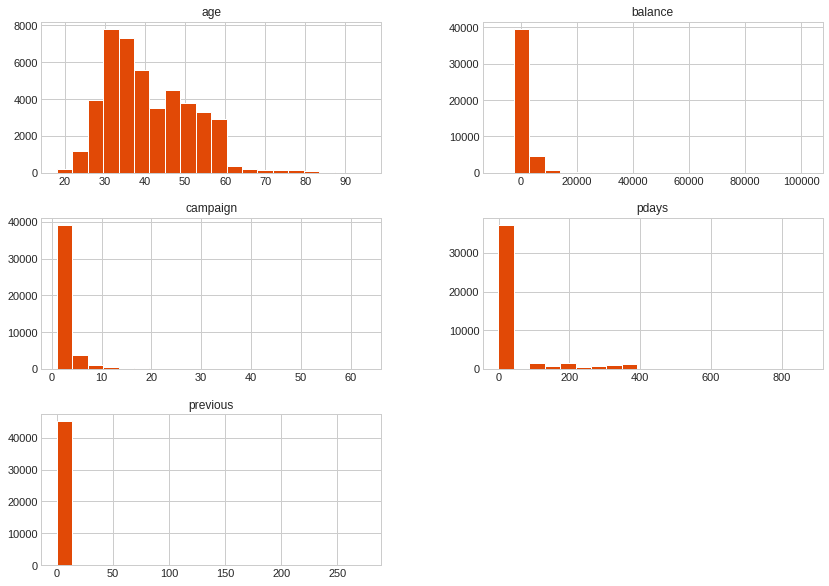

In [19]:
plt.style.use('seaborn-whitegrid')

data.hist(bins=20, figsize=(14,10), color='#E14906')
plt.show()

As we saw from the above statistics of the numeric variables there are potential outliars. Let's talk about some of the max values for some of our variables: <br>

1 - **Balance:** It's not really unheard of to have $81,000 in your checking account. For example, this would make sense from one with a high salary, intersted in saving.<br> 

2 - **pdays:** It's a bit unusual to contact a lead after 854 days (almost 2.5 years) although it is plausable. For instance, maybe after 100 days they were removed from the marketing list but a flag was raised that might indicate that the person is likly will open an account and therefore be put back on the marketing list. Although they were removed then added back, it's possible that they never stopped counting the days in between.<br>

3 - **previous:** Like the previous variables that we discussed this one is also plausable. If a client was in multiple campaigns spanning of many quarters or even years can certainly add up to over 50 contacts.<br>

4 - **Campaign:** Being contated over 60 time for one marketing campaign is a bit unheard of even for a campaign that lasts a year. Think about it, after reaching out to a person 20 don't you think they probably aren't interested? Also, most companies won't waste money like that. This will need more investigating. <br>


# Outliar Analysis

In [20]:
data.nlargest(20,"campaign")

age          job   marital  education  ... pdays  previous poutcome   y
4330    45   management   married    unknown  ...    -1         0  unknown  no
11914   24   technician    single    primary  ...    -1         0  unknown  no
5073    35   technician   married  secondary  ...    -1         0  unknown  no
4299    30   management    single   tertiary  ...    -1         0  unknown  no
5459    35  blue-collar   married  secondary  ...    -1         0  unknown  no
18713   35  blue-collar   married  secondary  ...    -1         0  unknown  no
10697   28  blue-collar    single  secondary  ...    -1         0  unknown  no
18744   49  blue-collar   married    primary  ...    -1         0  unknown  no
4275    40  blue-collar   married  secondary  ...    -1         0  unknown  no
13675   51  blue-collar   married    unknown  ...    -1         0  unknown  no
18660   33  blue-collar   married  secondary  ...    -1         0  unknown  no
4334    42  blue-collar   married    primary  ...    -1         0  unknown  no
11301   28  blue-collar    single  secondary  ...    -1         0  unknown  no
18616   34   management   married   tertiary  ...    -1         0  unknown  no
5721    48   management    single   tertiary  ...    -1         0  unknown  no
18704   44    housemaid   married    primary  ...    -1         0  unknown  no
23062   38   management   married   tertiary  ...    -1         0  unknown  no
9964    26  blue-collar    single    primary  ...    -1         0  unknown  no
11884   50  blue-collar  divorced    unknown  ...    -1         0  unknown  no
18513   57      retired   married    primary  ...    -1         0  unknown  no

[20 rows x 16 columns]

Based on the above data there is no indication of an error in the above data. It looks like all of the above data all have that they were previously not contacted before. I could be that possibly that the company wanted to take an aggesive approach to marketing to fresh leads. Because of this reasoning I will not take out any observations although I will make sure to keep this in mind. Although, I decided not to throw out any variables, there is certainly a strong case to be made for tossing rows or transforming the columns to adjust for the outliers.

# Data Cleaning: Catigorical Variables

In [21]:
#populate a list with string-type columns
str_columns = []
for i in data.columns:
    if(type(data[i][0])==str):
        str_columns.append(i)

In [22]:
print(str_columns)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'day', 'month', 'poutcome', 'y']


## Adjusting the Binary Categorical Variables

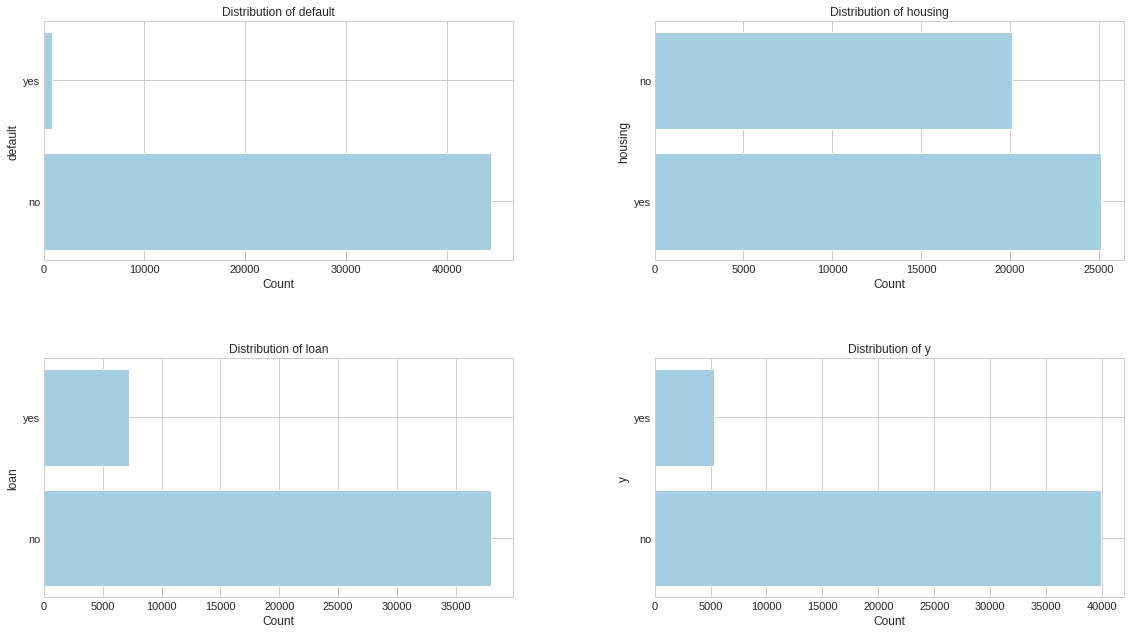

In [23]:
fig, axes = plt.subplots(2,2)
fig.tight_layout(h_pad=2)

bin_list = [3,4,5,10]

for i in range(1,5):
    plt.subplot(2, 2, i)
    n = bin_list[i-1]
    counts = data[str_columns[n]].value_counts()
    plt.barh(y=counts.index, width=counts)
    plt.title('Distribution of '+str_columns[n])
    plt.ylabel(str_columns[n])
    plt.xlabel('Count')

plt.subplots_adjust(left=.25, bottom=2, right=2.75, top=4)

In [24]:
# change the character values in the above columns to 0/1 binary values
# 0="no" and 1="yes"

data['default'] = [0 if i == "no" else 1 for i in data['default']]
data['housing'] = [0 if i == "no" else 1 for i in data['housing']]
data['loan']    = [0 if i == "no" else 1 for i in data['loan']   ]
data['y'] = [0 if i == "no" else 1 for i in data['y']]

In [25]:
#check
print(data['default'].value_counts())
print(data['housing'].value_counts())
print(data['loan'].value_counts())
print(data['y'].value_counts())

0    44396
1      815
Name: default, dtype: int64
1    25130
0    20081
Name: housing, dtype: int64
0    37967
1     7244
Name: loan, dtype: int64
0    39922
1     5289
Name: y, dtype: int64


In [26]:
#adjust our string list and remove the four variables above
for i in ['default','housing','loan','y']:
    str_columns.remove(i)
    
print(str_columns)

['job', 'marital', 'education', 'contact', 'day', 'month', 'poutcome']


In [27]:
data.head()

age           job  marital  education  ...  pdays  previous  poutcome  y
0   58    management  married   tertiary  ...     -1         0   unknown  0
1   44    technician   single  secondary  ...     -1         0   unknown  0
2   33  entrepreneur  married  secondary  ...     -1         0   unknown  0
3   47   blue-collar  married    unknown  ...     -1         0   unknown  0
4   33       unknown   single    unknown  ...     -1         0   unknown  0

[5 rows x 16 columns]

## Adjusting the other categorical variables

In [28]:
print(str_columns)

['job', 'marital', 'education', 'contact', 'day', 'month', 'poutcome']


Above we adjusted the binary categorical variables and turned them into numeric variables that we can work with. Now we can transform the categorical variables that contain more than one unique value using one-hot encoding. Before we transform the variables we must view the distribtion to get an idea of the behavior for each variable.

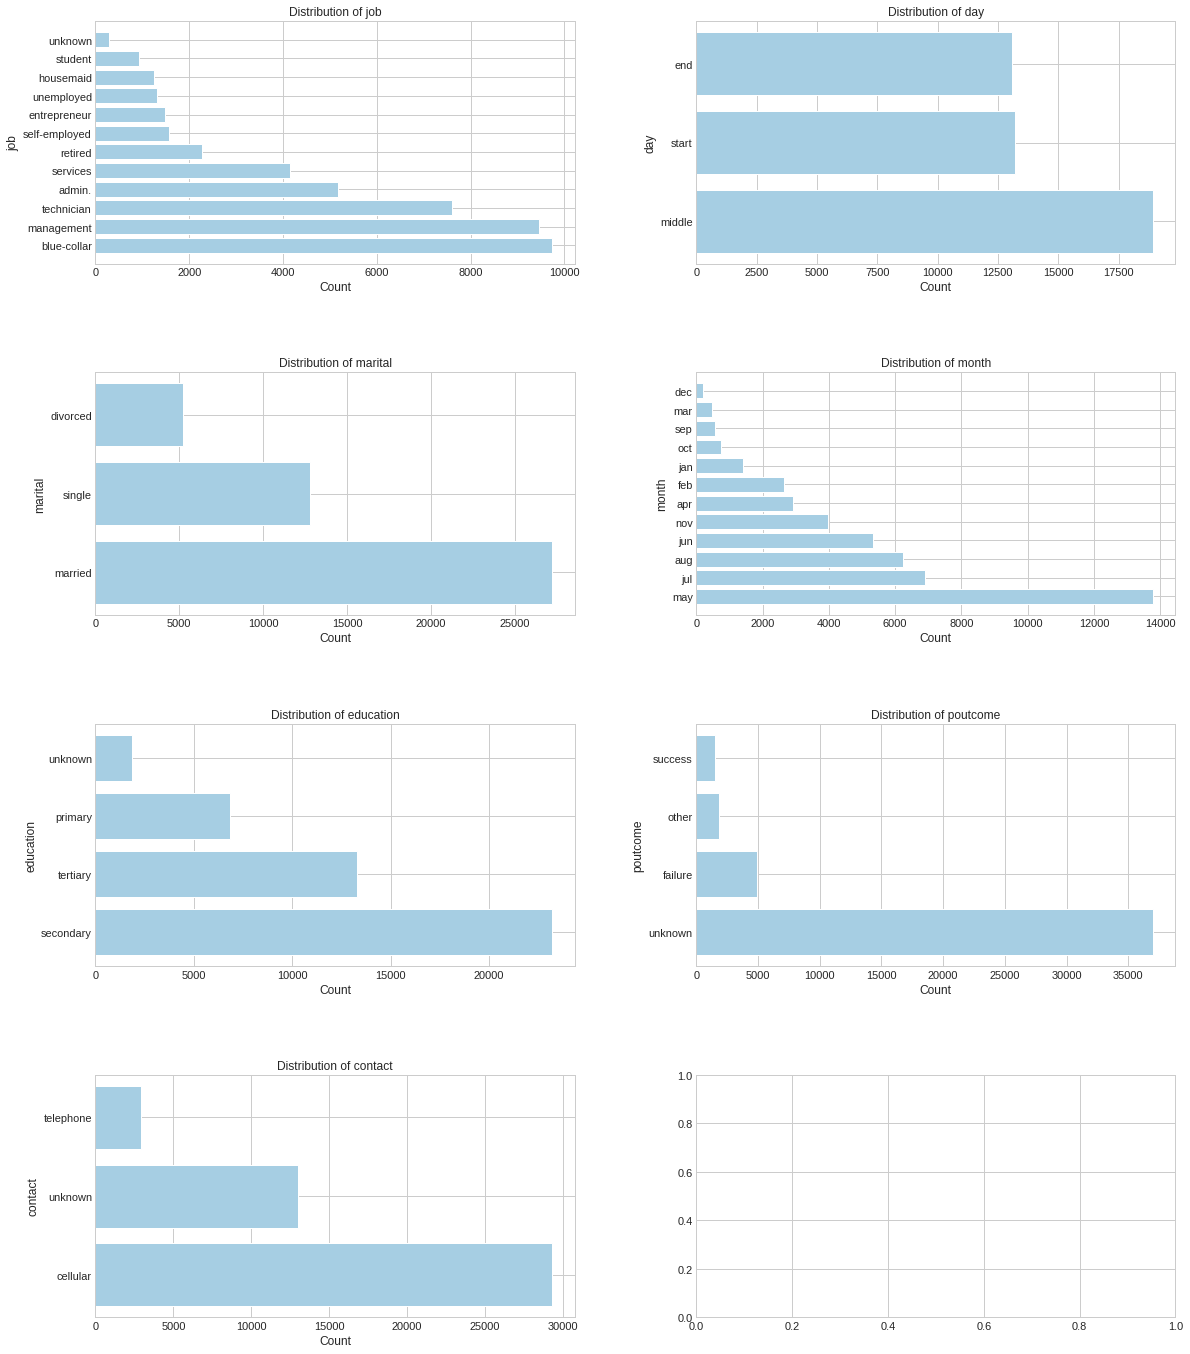

In [29]:
fig, axes = plt.subplots(4,2)
fig.tight_layout(h_pad=.25)

j = 0
k = 0 
for i in range(1,8):
    if k==4:
        k=0
        j=1
    plt.subplot2grid((4, 2), (k,j))
    n = i-1
    counts = data[str_columns[n]].value_counts()
    plt.barh(y=counts.index, width=counts)
    plt.title('Distribution of '+str_columns[n])
    plt.ylabel(str_columns[n])
    plt.xlabel('Count')
    k=k+1
                     
plt.subplots_adjust(left=.25, bottom=.5, right=2.75, top=5)

A few notes from the above distributions:

+ It's interesting that the largest volume of calls happen in the summer months and weakest in the colder months.
+ Remember that "poutcome" reflects how they responded to a previous campaign. We should note that about 75% in this category is labeled as "unknown" which is consistant with what we found earlier.
+ based on the demographic variables, it seems like this campaign targets middle class individuals which supports the statistics from our "balance" variable.  

This information will be valuable when we review the results of our final model

In [30]:
# let's use one-hot encodin to change the categorical variables to numericals
data = pd.get_dummies(data)
print(len(data.columns))
print(data.columns)

50
Index(['age', 'default', 'balance', 'housing', 'loan', 'campaign', 'pdays',
       'previous', 'y', 'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'job_unknown', 'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'contact_cellular', 'contact_telephone',
       'contact_unknown', 'day_end', 'day_middle', 'day_start', 'month_apr',
       'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')


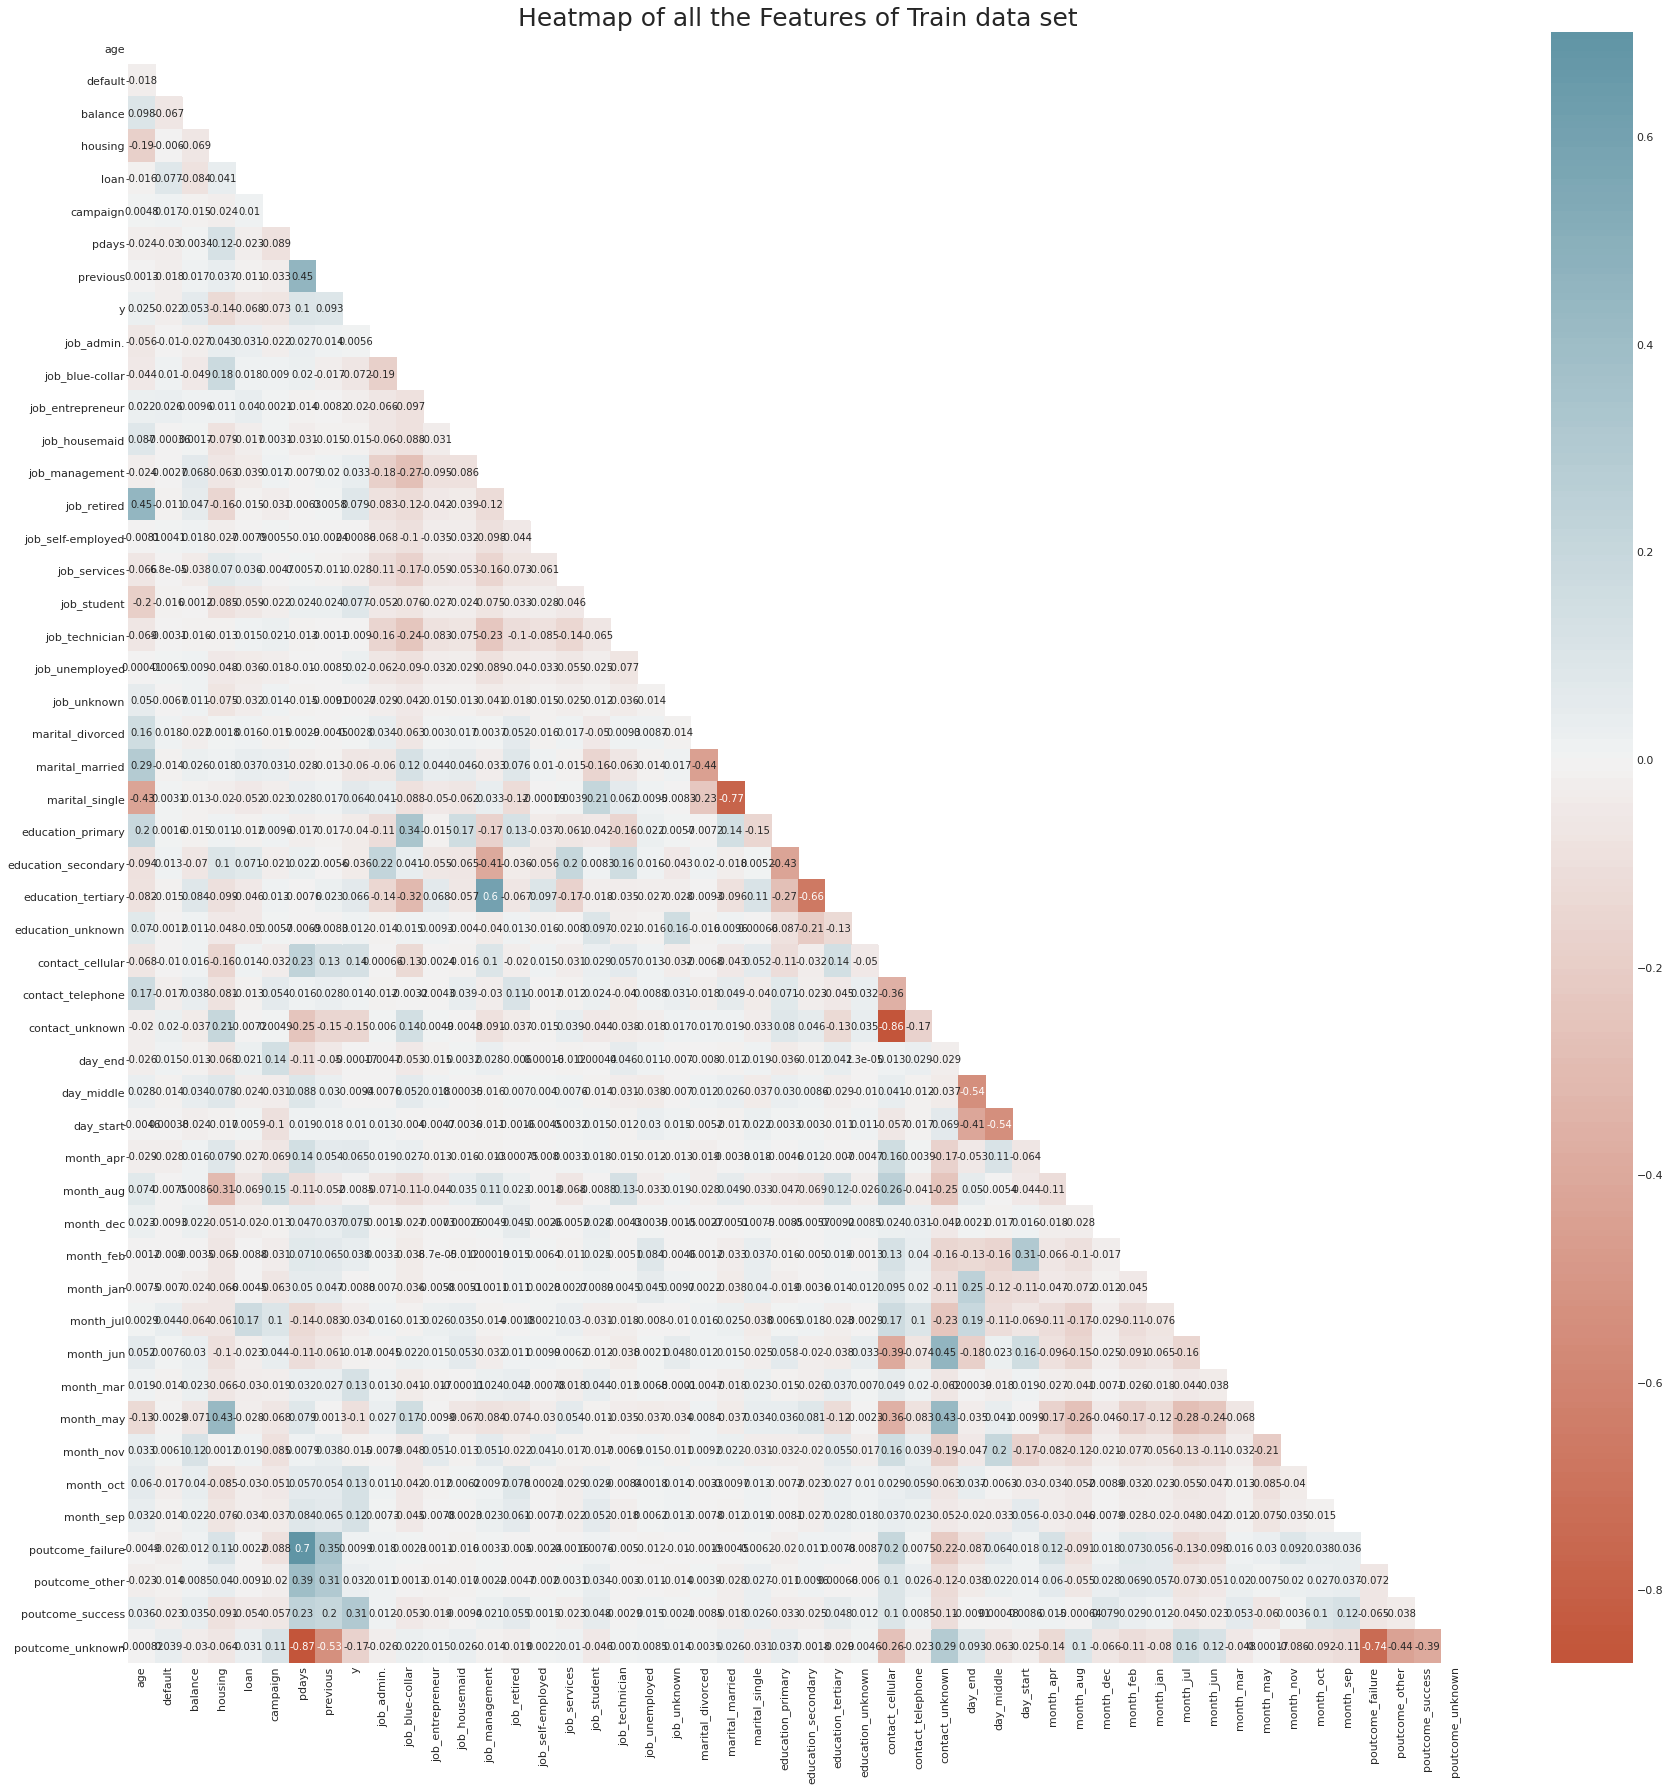

In [31]:
style.use('ggplot')
sns.set_style('whitegrid')
plt.subplots(figsize = (30,30))
## Plotting heatmap. Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(data.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data.corr(), cmap=sns.diverging_palette(20, 220, n=200), annot=True, mask=mask, center = 0, );
plt.title("Heatmap of all the Features of Train data set", fontsize = 25);

Based on the above correlation table the categorical variables that got encoded with exactly 3 unique values appear to have multicolinnearity. This can probably be attributed to the fact that 2 of the encoded values will together have information on the third. For example, if there are three choices between pcoucome (success, failure, unknown) and it wasn't a success or a failure, the data will assume it was unknown. Therefore we can remove one of these encoded variables from each of the categorical varible with three unique values.

In [32]:
   #delete: poutcome_unknown, marital_single, day_end, contact_unknown

data.pop("poutcome_unknown")
data.pop("marital_single")
data.pop("day_end")
data.pop("contact_unknown")
data.pop("education_unknown")

0        0
1        0
2        0
3        1
4        1
        ..
45206    0
45207    0
45208    0
45209    0
45210    0
Name: education_unknown, Length: 45211, dtype: uint8

In [33]:
dataset = data.copy(deep = True)

# Modeling

Below are a few functions to streamline our modeling

In [35]:
def Models(models, X_train, X_test, y_train, y_test, title):
    model = models
    model.fit(X_train,y_train)
    #Tune HPs
    
    X, y = Definedata()
    train_matrix = pd.crosstab(y_train, model.predict(X_train), rownames=['Actual'], colnames=['Predicted'])    
    test_matrix = pd.crosstab(y_test, model.predict(X_test), rownames=['Actual'], colnames=['Predicted'])
    matrix = pd.crosstab(y, model.predict(X), rownames=['Actual'], colnames=['Predicted'])
    
    f,(ax1,ax2,ax3) = plt.subplots(1,3,sharey=True, figsize=(20, 3))
    #f = plt.figure(figsize=(20, 3))
    
    g1 = sns.heatmap(train_matrix, annot=True, fmt=".1f", cbar=False,ax=ax1)
    g1.set_title(title)
    g1.set_ylabel('Total Deposit = {}'.format(y_train.sum()), fontsize=14, rotation=90)
    g1.set_xlabel('Accuracy score for Training Dataset = {}'.format(accuracy_score(model.predict(X_train), y_train)))
    g2 = sns.heatmap(test_matrix, annot=True, fmt=".1f",cbar=False,ax=ax2)
    g2.set_title(title)
    g2.set_ylabel('Total Deposit = {}'.format(y_test.sum()), fontsize=14, rotation=90)
    g2.set_xlabel('Accuracy score for Testing Dataset = {}'.format(accuracy_score(model.predict(X_test), y_test)))
    g3 = sns.heatmap(matrix, annot=True, fmt=".1f",cbar=False,ax=ax3)
    g3.set_title(title)
    g3.set_ylabel('Total Deposit = {}'.format(y.sum()), fontsize=14, rotation=90)
    g3.set_xlabel('Accuracy score for Total Dataset = {}'.format(accuracy_score(model.predict(X), y)))
    
    plt.show()
    
    yc = y_test
    #ypredc = model.predict(X_test)
    ypredc = model.predict_proba(X_test)

    fpr, tpr, thresholds = roc_curve(yc, ypredc[:,1])
    roc_auc = auc(fpr, tpr)
    

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.0])
    plt.ylim([-0.1,1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    precision, recall, thresholds = precision_recall_curve(yc, ypredc[:,1])
    auc_score = auc(recall, precision)
    print('auc score is: ', auc_score)
    pyplot.plot(recall, precision, marker='.')
    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()
    
    return y, model.predict(X)

In [36]:
import plotly.graph_objects as go

def Featureimportances(models, X_train, y_train):
    model = models
    model.fit(X_train,y_train)
    importances = model.feature_importances_
    features = data.columns
    if len(importances)<len(features): 
        features = data.columns[:len(importances)]
    else:
        importances = model.feature_importances_[:len(features)]
    imp = pd.DataFrame({'Features': features, 'Importance': importances})
    imp = imp.sort_values(by = 'Importance', ascending=False)[:20]
    imp['Sum Importance'] = imp['Importance'].cumsum()
    
    fig = go.Figure()
    fig.add_trace(go.Bar(x=imp.Features,y=imp.Importance, marker=dict(color=list(range(20)), colorscale="Sunsetdark")))

    fig.update_layout(title="Feature Importance",
                                 xaxis_title="Features", yaxis_title="Importance",title_x=0.5, paper_bgcolor="mintcream",
                                 title_font_size=20)
    fig.show()

In [37]:
def Definedata():
    # define dataset
    X_i=data.drop(columns=['y']).values
    y_i=data['y'].values
    ros = RandomOverSampler(random_state=0)
    X, y = ros.fit_resample(X_i, y_i)
    return X, y

In [38]:
# define dataset
data.dropna(inplace=True)
X_i=data.drop(columns=['y']).values
y_i=data['y'].values
ros = RandomOverSampler(random_state=0)
X, y = ros.fit_resample(X_i, y_i)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=2)

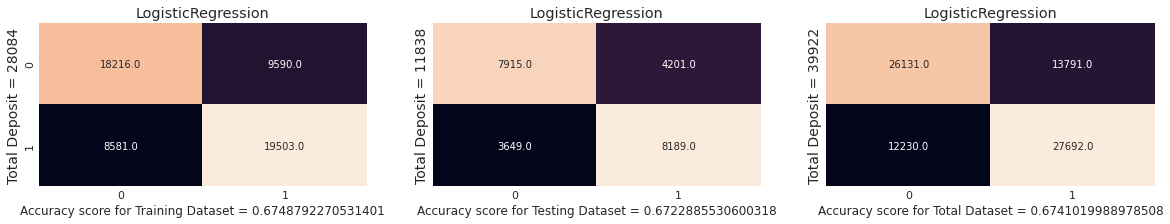

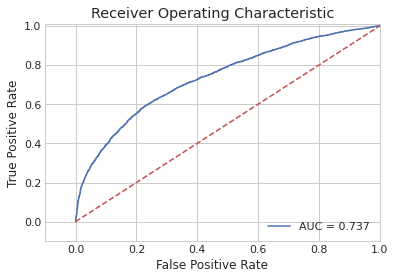

No handles with labels found to put in legend.


auc score is:  0.7421741898185545


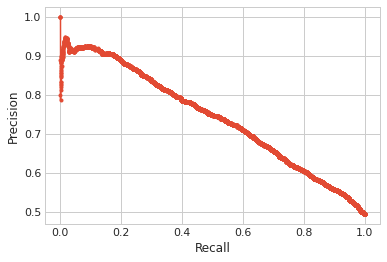

CPU times: user 3.54 s, sys: 1.72 s, total: 5.26 s
Wall time: 3.06 s


(array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 0]))

In [40]:
title = 'LogisticRegression'
%time Models(LogisticRegression(),X_train, X_test, y_train, y_test, title)

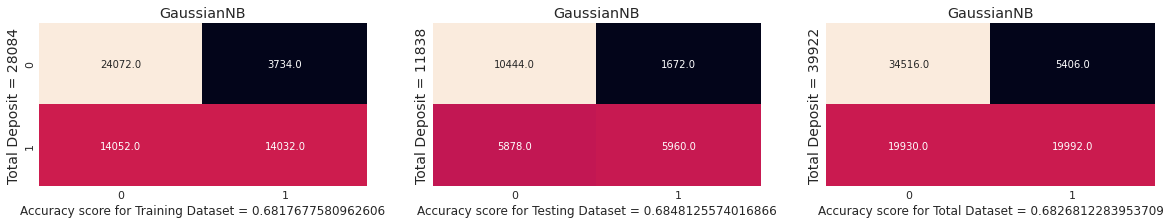

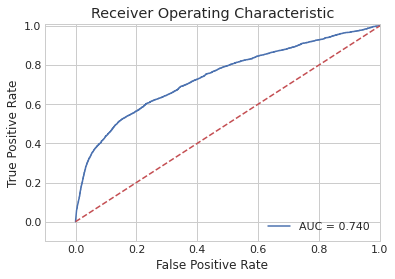

No handles with labels found to put in legend.


auc score is:  0.7570524256022116


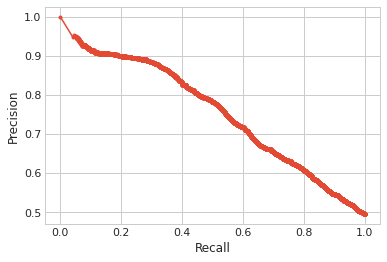

CPU times: user 1.51 s, sys: 145 ms, total: 1.65 s
Wall time: 1.55 s


(array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 0, 0, 0]))

In [41]:
title = 'GaussianNB'
%time Models(GaussianNB(),X_train, X_test, y_train, y_test, title)

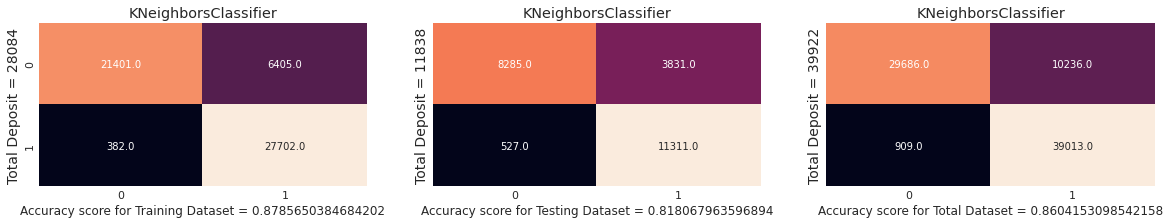

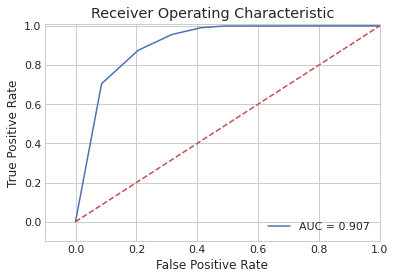

No handles with labels found to put in legend.


auc score is:  0.9043022913948876


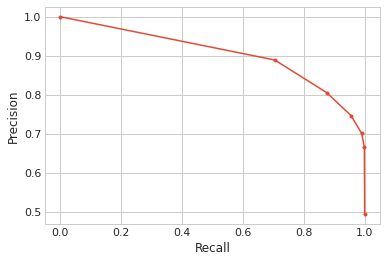

CPU times: user 34.2 s, sys: 214 ms, total: 34.4 s
Wall time: 34.2 s


(array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]))

In [52]:
title = 'KNeighborsClassifier'
%time Models(KNeighborsClassifier(n_neighbors=5),X_train, X_test, y_train, y_test, title)

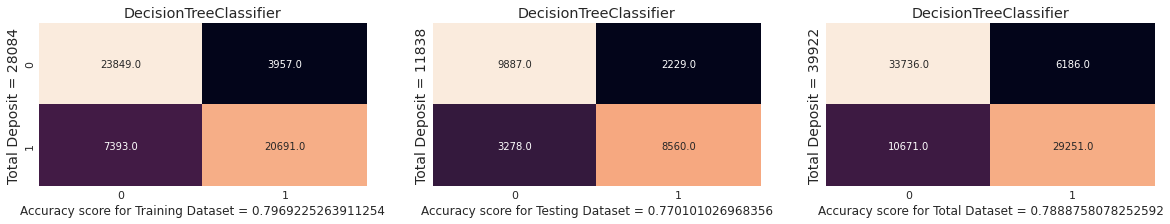

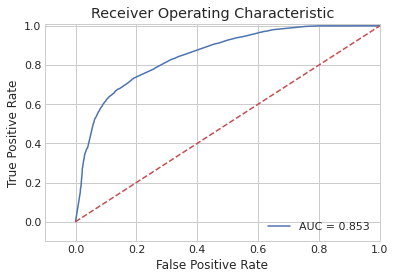

No handles with labels found to put in legend.


auc score is:  0.84205484057123


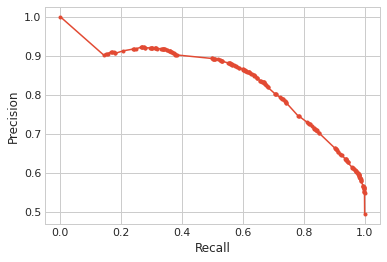

CPU times: user 1.82 s, sys: 132 ms, total: 1.95 s
Wall time: 1.84 s


(array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 0, 1, 1]))

In [43]:
title = 'DecisionTreeClassifier'
%time Models(DecisionTreeClassifier(max_depth=14),X_train, X_test, y_train, y_test, title)

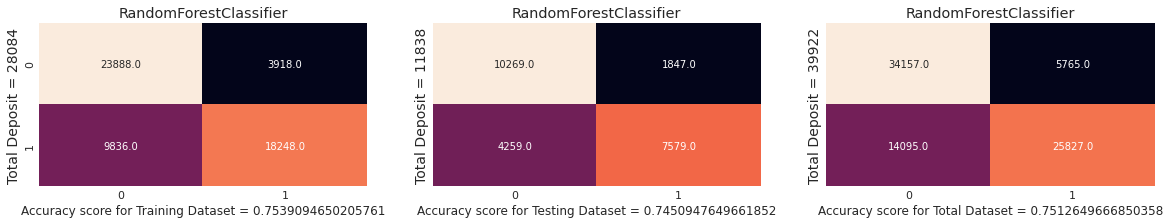

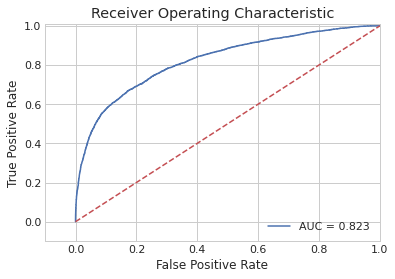

No handles with labels found to put in legend.


auc score is:  0.833752559793722


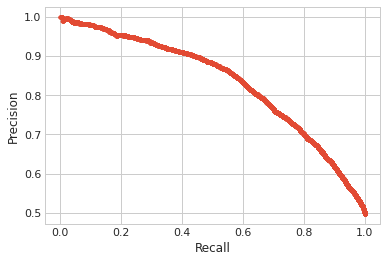

CPU times: user 9.86 s, sys: 155 ms, total: 10 s
Wall time: 9.87 s


(array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 0]))

In [50]:
title = 'RandomForestClassifier'
%time Models(RandomForestClassifier(max_depth=10),X_train, X_test, y_train, y_test, title)

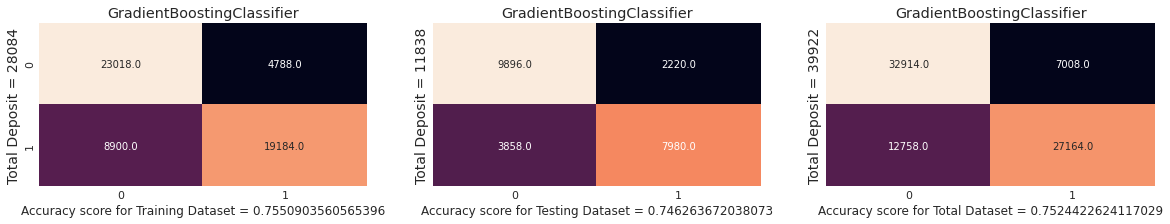

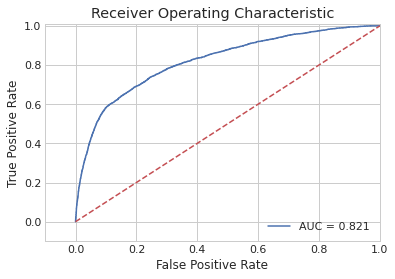

No handles with labels found to put in legend.


auc score is:  0.8223153259261147


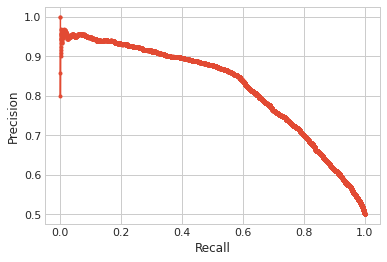

CPU times: user 11.4 s, sys: 213 ms, total: 11.6 s
Wall time: 11.4 s


(array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 0, 1, 1]))

In [45]:
title = 'GradientBoostingClassifier'
%time Models(GradientBoostingClassifier(n_estimators=500, learning_rate=1, max_features=2, max_depth=2, random_state=0),X_train, X_test, y_train, y_test, title)

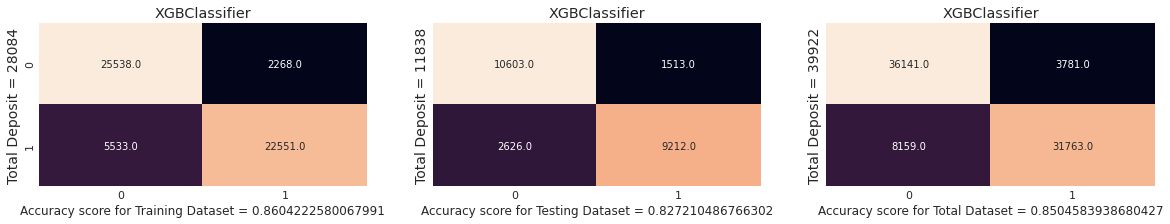

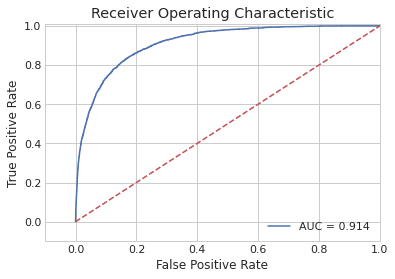

No handles with labels found to put in legend.


auc score is:  0.905056357709178


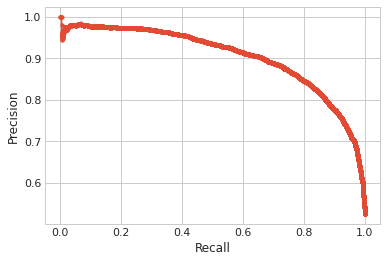

CPU times: user 26.5 s, sys: 166 ms, total: 26.6 s
Wall time: 26.4 s


(array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]))

In [51]:
title = 'XGBClassifier'
%time Models(XGBClassifier(max_depth=10),X_train, X_test, y_train, y_test, title)

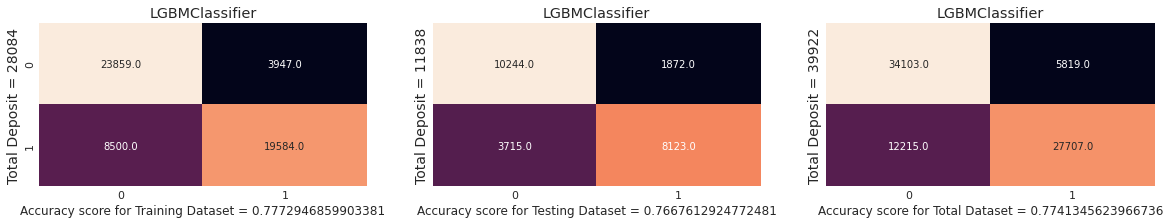

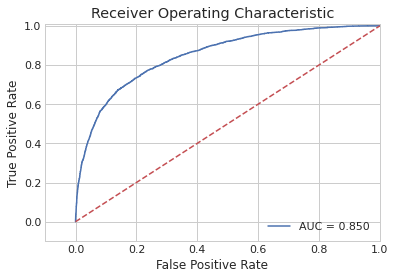

No handles with labels found to put in legend.


auc score is:  0.846955173521224


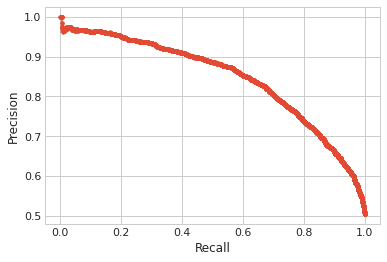

CPU times: user 4.26 s, sys: 154 ms, total: 4.41 s
Wall time: 4.28 s


(array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 0, 1, 0]))

In [47]:
title = 'LGBMClassifier'
%time Models(LGBMClassifier(),X_train, X_test, y_train, y_test, title)

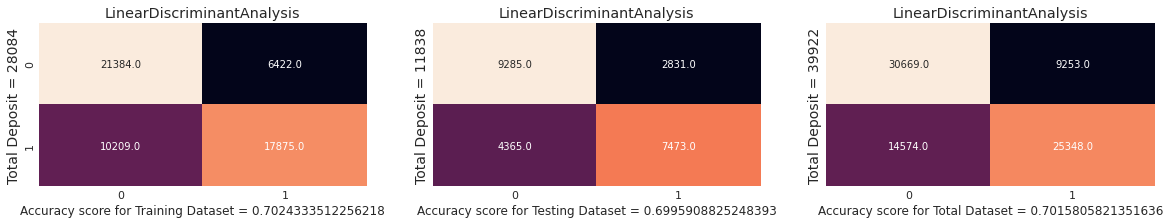

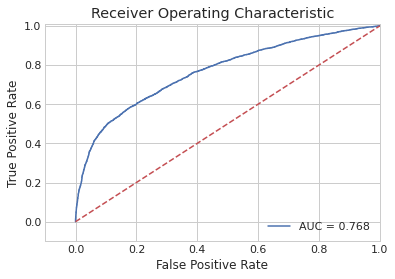

No handles with labels found to put in legend.


auc score is:  0.7820183051985541


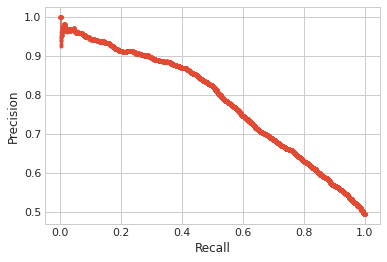

CPU times: user 2.01 s, sys: 715 ms, total: 2.73 s
Wall time: 1.92 s


(array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 0, 1, 0]))

In [48]:
title = 'LinearDiscriminantAnalysis'
%time Models(LinearDiscriminantAnalysis(),X_train, X_test, y_train, y_test, title)

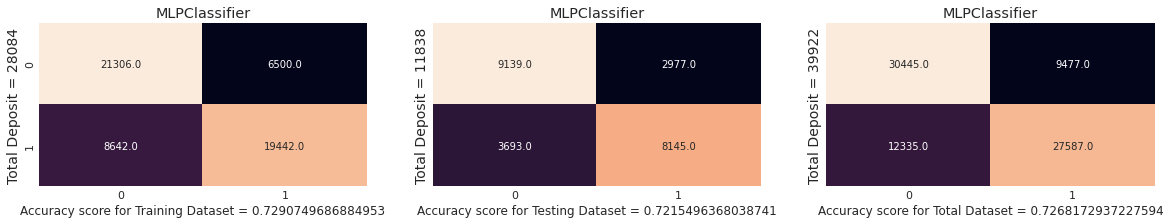

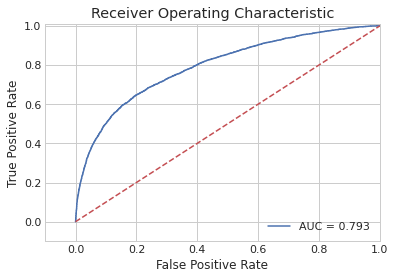

No handles with labels found to put in legend.


auc score is:  0.7964758871946394


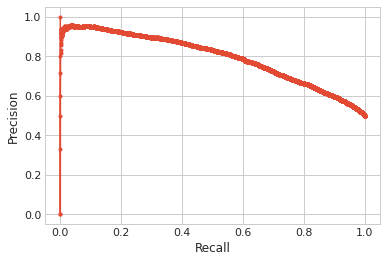

CPU times: user 32.5 s, sys: 24.5 s, total: 57 s
Wall time: 29.5 s


(array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 0, 1, 0]))

In [49]:
from sklearn.neural_network import MLPClassifier
title = 'MLPClassifier'
%time Models(MLPClassifier(hidden_layer_sizes=(40,15), max_iter=1000),X_train, X_test, y_train, y_test, title)

# SHAP

In [53]:
!pip install shap

     |████████████████████████████████| 358kB 5.3MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491633 sha256=3fd6b81c0ad9a8e70174023d0e2663edc83527d6b42162ea3e07d7df4525db09
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [55]:
dataset.dropna(inplace=True)
X_i=dataset.drop(columns=['y']).values
y_i=dataset['y'].values
ros = RandomOverSampler(random_state=0)
X, y = ros.fit_resample(X_i, y_i)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=2)

In [65]:
import xgboost
import shap

# load JS visualization code to notebook
shap.initjs()

# train XGBoost model
#model = xgboost.train({"learning_rate": 0.001}, xgboost.DMatrix(X_train, label=y_train), 1000)

model = xgboost.XGBClassifier()
model.fit(X_train, y_train)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

In [71]:
X = pd.DataFrame(X, columns=dataset.drop(columns=['y']).columns)
X_test = pd.DataFrame(X_test, columns=dataset.drop(columns=['y']).columns)

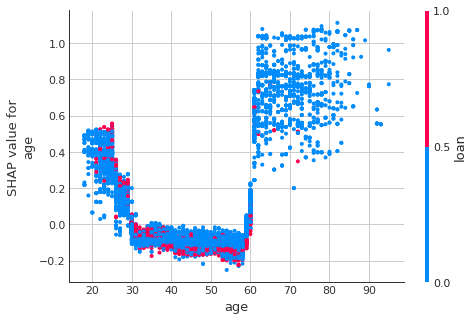

In [74]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("age", shap_values, X_test)

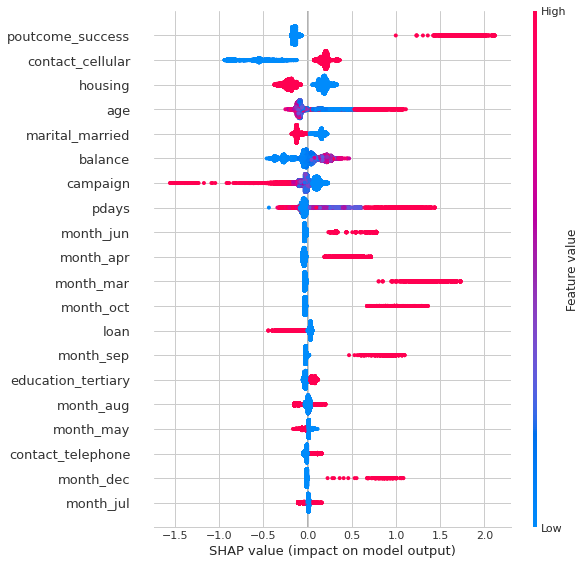

In [75]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_test)

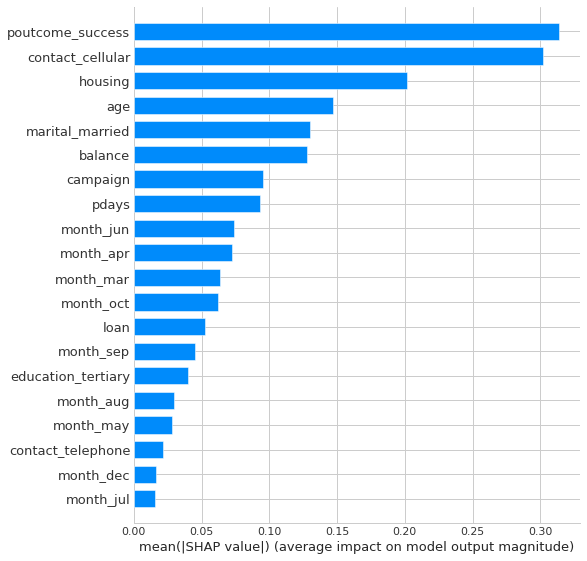

In [76]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [79]:
result = X_test.copy(deep = True)
result['Prediction'] = model.predict(X_test.to_numpy())
result['Probability'] = model.predict_proba(X_test.to_numpy())[:,1]

In [80]:
result.head()

age  default  balance  ...  poutcome_success  Prediction  Probability
0   42        0        9  ...                 0           0     0.367081
1   26        0      -93  ...                 0           0     0.458458
2   33        0     -634  ...                 0           0     0.400458
3   39        0     -114  ...                 0           0     0.403916
4   35        0      538  ...                 0           0     0.219759

[5 rows x 46 columns]

In [81]:
target_customer = result[result['Prediction'] == 1]
print(len(target_customer))

9602


In [82]:
index = shap_values.argmax(axis = 1)
result['Important Attribute'] = X_test.columns[index]

In [83]:
def potential_customers(df: pd.DataFrame, cut_off = 0.5):
    potential_customers = df[df['Probability'] >= cut_off]
    non_potential_customers = len(df) - len(potential_customers)
    return potential_customers, len(potential_customers), non_potential_customers

In [84]:
cut_offs = np.linspace(0,1,100)
num_customers = []
non_potential_customers = []
for i in cut_offs:
    _, num_customer, non_potential_customer = potential_customers(result, i)
    num_customers.append(num_customer)
    non_potential_customers.append(non_potential_customer)

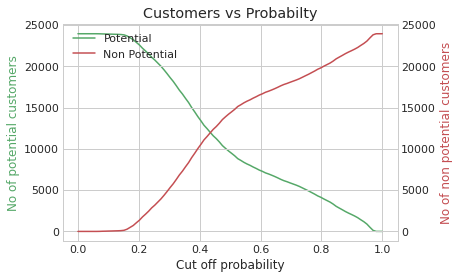

In [85]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

# create line plot of y1(x)
line1, = ax1.plot(cut_offs, num_customers , 'g', label="Potential")
ax1.set_xlabel('Cut off probability')
ax1.set_ylabel('No of potential customers', color='g')

# create shared axis for y2(x)
ax2 = ax1.twinx()

# create line plot of y2(x)
line2, = ax2.plot(cut_offs, non_potential_customers , 'r', label="Non Potential")
ax2.set_ylabel('No of non potential customers', color='r')

# set title, plot limits, etc
plt.title('Customers vs Probabilty')


# add a legend, and position it on the upper right
plt.legend((line1, line2), ('Potential', 'Non Potential'))

plt.show()

In [86]:
result.head()

age  default  balance  ...  Prediction  Probability  Important Attribute
0   42        0        9  ...           0     0.367081     contact_cellular
1   26        0      -93  ...           0     0.458458                  age
2   33        0     -634  ...           0     0.400458     contact_cellular
3   39        0     -114  ...           0     0.403916     contact_cellular
4   35        0      538  ...           0     0.219759      marital_married

[5 rows x 47 columns]

In [87]:
def important_features(df: pd.DataFrame, X_test: pd.DataFrame, shap_values: np.ndarray):
    PositiveSHAPfeatures = []
    for i in range(len(df)):
        ind = [j for j in range(len(shap_values[i])) if shap_values[i][j]>0]
        PositiveSHAPfeatures.append(X_test.columns[ind])
    df['PositiveSHAPfeatures'] = PositiveSHAPfeatures
    return df

In [88]:
result = important_features(result, X_test, shap_values)

In [89]:
result.head()

age  ...                               PositiveSHAPfeatures
0   42  ...  Index(['loan', 'campaign', 'job_blue-collar', ...
1   26  ...  Index(['age', 'loan', 'job_retired', 'job_serv...
2   33  ...  Index(['campaign', 'job_blue-collar', 'job_man...
3   39  ...  Index(['loan', 'campaign', 'job_blue-collar', ...
4   35  ...  Index(['job_blue-collar', 'job_retired', 'job_...

[5 rows x 48 columns]

In [90]:
result.to_excel('target_customer.xlsx')

KeyboardInterrupt: ignored

# Analyze the Strongest Model

Let's take a closer look at the XGBClassifier since that was one of our most predictive models

Above we have our 3 confustion matricies along with an ROC curve.To briefly analyze the confusion matricies, we have a strong Accuracy for our test set with a value of about 0.895 and a strong Accuacy for our full dataset with an Accuracy of about 0.914. 

Below the confustion matricies, we can see the ROC curve with a value of 0.625 which is not very strong. The ROC curve shows the trade-off between sensitivity (or TPR) and specificity (1 – FPR). Classifiers that give curves closer to the top-left corner indicate a better performance. As a baseline, a random classifier is expected to give points lying along the diagonal (FPR = TPR). The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test. In other words, the 45-degree line represents randomly choosing an outcome.

In [91]:
Featureimportances(XGBClassifier(), X_train, y_train)

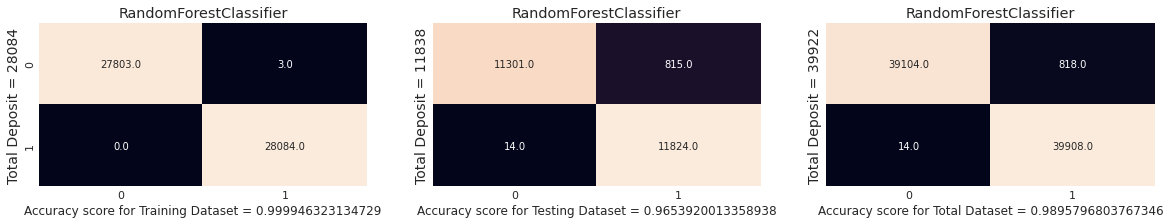

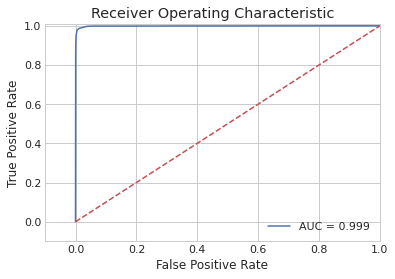

No handles with labels found to put in legend.


auc score is:  0.9988653106638266


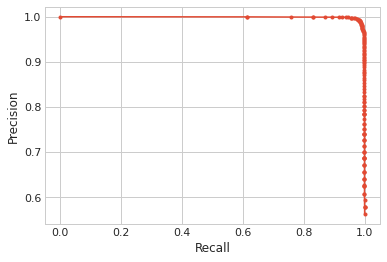

CPU times: user 18.6 s, sys: 238 ms, total: 18.9 s
Wall time: 18.7 s


(array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]))

In [92]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {'bootstrap': [True],
     'max_depth': [6, 20],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [3, 10],
     'min_samples_split': [4, 10],
     'n_estimators': [100, 1000]
    }
     

model = RandomForestClassifier()

best_model = RandomizedSearchCV(model, param_grid, cv=5,
                                  scoring="accuracy",
                                  return_train_score=True,
                                  verbose=True,
                                  n_jobs=-1)

title = 'RandomForestClassifier'
%time Models(RandomForestClassifier(),X_train, X_test, y_train, y_test, title)

In [93]:
!pip install optuna
import optuna

     |████████████████████████████████| 296kB 4.8MB/s 
     |████████████████████████████████| 81kB 5.3MB/s 
     |████████████████████████████████| 163kB 7.3MB/s 
     |████████████████████████████████| 143kB 7.3MB/s 
     |████████████████████████████████| 112kB 8.5MB/s 
     |████████████████████████████████| 51kB 4.5MB/s 
     |████████████████████████████████| 81kB 5.7MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-cp37-none-any.whl size=11107 sha256=3986166bae04a8b710b31df8a18f6e5325aae71ee676381ddb05217e7d2d39aa
  Stored in directory: /root/.cache/pip/wheels/25/af/b8/3407109267803f4015e1ee2ff23be0c8c19ce4008665931ee1
Successfully built pyperclip


In [94]:
import xgboost as xgb

In [95]:
def objective(trial):
    X, y = Definedata()
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=2)
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dtest = xgb.DMatrix(test_x, label=test_y)

    tree_method = ['exact','approx','hist']
    boosting_list = ['gbtree', 'gblinear']
    objective_list_reg = ['reg:linear', 'reg:gamma', 'reg:tweedie']
    params ={'boosting':trial.suggest_categorical('boosting', boosting_list),
            'tree_method':trial.suggest_categorical('tree_method', tree_method),
            'max_depth':trial.suggest_int('max_depth', 2, 25),
            'reg_alpha':trial.suggest_int('reg_alpha', 0, 5),
            'reg_lambda':trial.suggest_int('reg_lambda', 0, 5),
            'min_child_weight':trial.suggest_int('min_child_weight', 0, 5),
            'gamma':trial.suggest_int('gamma', 0, 5),
            'learning_rate':trial.suggest_loguniform('learning_rate',0.005,0.5)
            }

    #model = XGBClassifier(params)
    #model.fit(train_x, train_y)
    model = xgb.train(params,dtrain,evals=[(dtest, "Test")],early_stopping_rounds=10)
    preds = model.predict(dtest)
    accuracy = accuracy_score(preds.round(), test_y)
    return accuracy

In [96]:
study = optuna.create_study()
history = study.optimize(objective, n_trials=100)
print(study.best_trial)

[I 2021-04-24 21:56:26,203] A new study created in memory with name: no-name-19fafa86-0b46-42a2-bf37-bd6e56435c9a


[0]	Test-rmse:0.44712
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.413392
[2]	Test-rmse:0.393182
[3]	Test-rmse:0.379984
[4]	Test-rmse:0.371429
[5]	Test-rmse:0.36467
[6]	Test-rmse:0.360833
[7]	Test-rmse:0.357461
[8]	Test-rmse:0.354484
[9]	Test-rmse:0.353335


[I 2021-04-24 21:56:41,117] Trial 0 finished with value: 0.8433664523670368 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'max_depth': 25, 'reg_alpha': 0, 'reg_lambda': 2, 'min_child_weight': 5, 'gamma': 3, 'learning_rate': 0.25449188260835504}. Best is trial 0 with value: 0.8433664523670368.


[0]	Test-rmse:0.488841
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.479067
[2]	Test-rmse:0.470417
[3]	Test-rmse:0.462559
[4]	Test-rmse:0.455472
[5]	Test-rmse:0.44927
[6]	Test-rmse:0.443856
[7]	Test-rmse:0.439143
[8]	Test-rmse:0.434901
[9]	Test-rmse:0.431069


[I 2021-04-24 21:56:47,390] Trial 1 finished with value: 0.7728563079235201 and parameters: {'boosting': 'gbtree', 'tree_method': 'exact', 'max_depth': 19, 'reg_alpha': 4, 'reg_lambda': 3, 'min_child_weight': 3, 'gamma': 3, 'learning_rate': 0.0733057028243187}. Best is trial 1 with value: 0.7728563079235201.


[0]	Test-rmse:0.499456
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.498898
[2]	Test-rmse:0.498367
[3]	Test-rmse:0.497834
[4]	Test-rmse:0.497297
[5]	Test-rmse:0.496777
[6]	Test-rmse:0.496255
[7]	Test-rmse:0.495735
[8]	Test-rmse:0.495209
[9]	Test-rmse:0.494703


[I 2021-04-24 21:56:47,935] Trial 2 finished with value: 0.7028471236536695 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'max_depth': 6, 'reg_alpha': 5, 'reg_lambda': 1, 'min_child_weight': 0, 'gamma': 0, 'learning_rate': 0.005047222103269918}. Best is trial 2 with value: 0.7028471236536695.


[0]	Test-rmse:0.496455
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.493063
[2]	Test-rmse:0.489789
[3]	Test-rmse:0.48666
[4]	Test-rmse:0.483648
[5]	Test-rmse:0.480741
[6]	Test-rmse:0.477938
[7]	Test-rmse:0.475309
[8]	Test-rmse:0.472733
[9]	Test-rmse:0.470237


[I 2021-04-24 21:56:54,047] Trial 3 finished with value: 0.746263672038073 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'max_depth': 11, 'reg_alpha': 1, 'reg_lambda': 4, 'min_child_weight': 1, 'gamma': 1, 'learning_rate': 0.02377908140715283}. Best is trial 2 with value: 0.7028471236536695.


[0]	Test-rmse:0.497971
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.496086
[2]	Test-rmse:0.494329
[3]	Test-rmse:0.492621
[4]	Test-rmse:0.491052
[5]	Test-rmse:0.489568
[6]	Test-rmse:0.488149
[7]	Test-rmse:0.48678
[8]	Test-rmse:0.485534
[9]	Test-rmse:0.484315


[I 2021-04-24 21:56:55,738] Trial 4 finished with value: 0.6516239458963012 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'max_depth': 2, 'reg_alpha': 1, 'reg_lambda': 2, 'min_child_weight': 2, 'gamma': 2, 'learning_rate': 0.033577616036445004}. Best is trial 4 with value: 0.6516239458963012.


[0]	Test-rmse:0.480604
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.465739
[2]	Test-rmse:0.454412
[3]	Test-rmse:0.445901
[4]	Test-rmse:0.438811
[5]	Test-rmse:0.433013
[6]	Test-rmse:0.428357
[7]	Test-rmse:0.425361
[8]	Test-rmse:0.42243
[9]	Test-rmse:0.419339


[I 2021-04-24 21:57:01,238] Trial 5 finished with value: 0.7533188611505385 and parameters: {'boosting': 'gblinear', 'tree_method': 'approx', 'max_depth': 10, 'reg_alpha': 5, 'reg_lambda': 1, 'min_child_weight': 3, 'gamma': 1, 'learning_rate': 0.150406291907683}. Best is trial 4 with value: 0.6516239458963012.


[0]	Test-rmse:0.467391
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.444878
[2]	Test-rmse:0.429034
[3]	Test-rmse:0.418076
[4]	Test-rmse:0.409828
[5]	Test-rmse:0.402977
[6]	Test-rmse:0.398134
[7]	Test-rmse:0.395911
[8]	Test-rmse:0.391832
[9]	Test-rmse:0.388211


[I 2021-04-24 21:57:02,136] Trial 6 finished with value: 0.7928112215078901 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'max_depth': 12, 'reg_alpha': 0, 'reg_lambda': 2, 'min_child_weight': 2, 'gamma': 2, 'learning_rate': 0.2164452377159119}. Best is trial 4 with value: 0.6516239458963012.


[0]	Test-rmse:0.455215
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.435775
[2]	Test-rmse:0.426635
[3]	Test-rmse:0.421117
[4]	Test-rmse:0.418511
[5]	Test-rmse:0.415502
[6]	Test-rmse:0.413211
[7]	Test-rmse:0.412339
[8]	Test-rmse:0.410573
[9]	Test-rmse:0.410077


[I 2021-04-24 21:57:04,816] Trial 7 finished with value: 0.7558236620188695 and parameters: {'boosting': 'gblinear', 'tree_method': 'exact', 'max_depth': 10, 'reg_alpha': 4, 'reg_lambda': 4, 'min_child_weight': 5, 'gamma': 3, 'learning_rate': 0.39634065160361714}. Best is trial 4 with value: 0.6516239458963012.


[0]	Test-rmse:0.494667
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.489674
[2]	Test-rmse:0.484965
[3]	Test-rmse:0.480583
[4]	Test-rmse:0.476503
[5]	Test-rmse:0.472703
[6]	Test-rmse:0.469164
[7]	Test-rmse:0.465908
[8]	Test-rmse:0.462783
[9]	Test-rmse:0.459902


[I 2021-04-24 21:57:05,554] Trial 8 finished with value: 0.7323620272188361 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'max_depth': 10, 'reg_alpha': 3, 'reg_lambda': 1, 'min_child_weight': 0, 'gamma': 2, 'learning_rate': 0.03929952368845656}. Best is trial 4 with value: 0.6516239458963012.


[0]	Test-rmse:0.496805
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.493742
[2]	Test-rmse:0.490798
[3]	Test-rmse:0.487969
[4]	Test-rmse:0.485241
[5]	Test-rmse:0.482614
[6]	Test-rmse:0.480118
[7]	Test-rmse:0.477632
[8]	Test-rmse:0.475232
[9]	Test-rmse:0.472922


[I 2021-04-24 21:57:19,062] Trial 9 finished with value: 0.7715621608082157 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'max_depth': 25, 'reg_alpha': 2, 'reg_lambda': 5, 'min_child_weight': 3, 'gamma': 3, 'learning_rate': 0.018647633582597443}. Best is trial 4 with value: 0.6516239458963012.


[0]	Test-rmse:0.499397
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.498823
[2]	Test-rmse:0.498208
[3]	Test-rmse:0.497653
[4]	Test-rmse:0.497083
[5]	Test-rmse:0.496546
[6]	Test-rmse:0.496002
[7]	Test-rmse:0.495433
[8]	Test-rmse:0.494924
[9]	Test-rmse:0.494357


[I 2021-04-24 21:57:21,160] Trial 10 finished with value: 0.658887868414461 and parameters: {'boosting': 'gblinear', 'tree_method': 'approx', 'max_depth': 3, 'reg_alpha': 1, 'reg_lambda': 3, 'min_child_weight': 2, 'gamma': 5, 'learning_rate': 0.007911927870044735}. Best is trial 4 with value: 0.6516239458963012.


[0]	Test-rmse:0.499703
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.499396
[2]	Test-rmse:0.499102
[3]	Test-rmse:0.498794
[4]	Test-rmse:0.498506
[5]	Test-rmse:0.498222
[6]	Test-rmse:0.497935
[7]	Test-rmse:0.497644
[8]	Test-rmse:0.497349
[9]	Test-rmse:0.497065


[I 2021-04-24 21:57:22,865] Trial 11 finished with value: 0.6084161309175921 and parameters: {'boosting': 'gblinear', 'tree_method': 'approx', 'max_depth': 2, 'reg_alpha': 1, 'reg_lambda': 3, 'min_child_weight': 2, 'gamma': 5, 'learning_rate': 0.005017987283083898}. Best is trial 11 with value: 0.6084161309175921.


[0]	Test-rmse:0.499247
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.498505
[2]	Test-rmse:0.497786
[3]	Test-rmse:0.497065
[4]	Test-rmse:0.496357
[5]	Test-rmse:0.49568
[6]	Test-rmse:0.495044
[7]	Test-rmse:0.494384
[8]	Test-rmse:0.493755
[9]	Test-rmse:0.493158


[I 2021-04-24 21:57:24,553] Trial 12 finished with value: 0.6516239458963012 and parameters: {'boosting': 'gblinear', 'tree_method': 'approx', 'max_depth': 2, 'reg_alpha': 1, 'reg_lambda': 0, 'min_child_weight': 1, 'gamma': 5, 'learning_rate': 0.012519988961491212}. Best is trial 11 with value: 0.6084161309175921.


[0]	Test-rmse:0.493247
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.487284
[2]	Test-rmse:0.482077
[3]	Test-rmse:0.47745
[4]	Test-rmse:0.473515
[5]	Test-rmse:0.469975
[6]	Test-rmse:0.466784
[7]	Test-rmse:0.464029
[8]	Test-rmse:0.461593
[9]	Test-rmse:0.459279


[I 2021-04-24 21:57:27,486] Trial 13 finished with value: 0.7055606579276947 and parameters: {'boosting': 'gblinear', 'tree_method': 'approx', 'max_depth': 5, 'reg_alpha': 2, 'reg_lambda': 4, 'min_child_weight': 4, 'gamma': 4, 'learning_rate': 0.06957072405764356}. Best is trial 11 with value: 0.6084161309175921.


[0]	Test-rmse:0.499088
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.498194
[2]	Test-rmse:0.497304
[3]	Test-rmse:0.496427
[4]	Test-rmse:0.495566
[5]	Test-rmse:0.494709
[6]	Test-rmse:0.493858
[7]	Test-rmse:0.493028
[8]	Test-rmse:0.492189
[9]	Test-rmse:0.491387


[I 2021-04-24 21:57:37,531] Trial 14 finished with value: 0.75761876930784 and parameters: {'boosting': 'gblinear', 'tree_method': 'approx', 'max_depth': 17, 'reg_alpha': 0, 'reg_lambda': 3, 'min_child_weight': 1, 'gamma': 4, 'learning_rate': 0.005310470383406284}. Best is trial 11 with value: 0.6084161309175921.


[0]	Test-rmse:0.495636
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.491589
[2]	Test-rmse:0.487799
[3]	Test-rmse:0.48422
[4]	Test-rmse:0.480958
[5]	Test-rmse:0.477929
[6]	Test-rmse:0.475062
[7]	Test-rmse:0.472366
[8]	Test-rmse:0.469897
[9]	Test-rmse:0.467508


[I 2021-04-24 21:57:39,341] Trial 15 finished with value: 0.7141604742422978 and parameters: {'boosting': 'gblinear', 'tree_method': 'exact', 'max_depth': 7, 'reg_alpha': 1, 'reg_lambda': 2, 'min_child_weight': 2, 'gamma': 1, 'learning_rate': 0.03696738683041402}. Best is trial 11 with value: 0.6084161309175921.


[0]	Test-rmse:0.499368
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.498734
[2]	Test-rmse:0.498132
[3]	Test-rmse:0.497517
[4]	Test-rmse:0.496925
[5]	Test-rmse:0.496361
[6]	Test-rmse:0.495789
[7]	Test-rmse:0.495245
[8]	Test-rmse:0.494695
[9]	Test-rmse:0.494174


[I 2021-04-24 21:57:41,026] Trial 16 finished with value: 0.6516239458963012 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'max_depth': 2, 'reg_alpha': 2, 'reg_lambda': 5, 'min_child_weight': 4, 'gamma': 0, 'learning_rate': 0.010477315427586625}. Best is trial 11 with value: 0.6084161309175921.


[0]	Test-rmse:0.498446
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.496908
[2]	Test-rmse:0.495399
[3]	Test-rmse:0.493919
[4]	Test-rmse:0.492429
[5]	Test-rmse:0.490984
[6]	Test-rmse:0.489547
[7]	Test-rmse:0.48814
[8]	Test-rmse:0.48675
[9]	Test-rmse:0.485384


[I 2021-04-24 21:57:49,487] Trial 17 finished with value: 0.7732320280537697 and parameters: {'boosting': 'gblinear', 'tree_method': 'approx', 'max_depth': 15, 'reg_alpha': 3, 'reg_lambda': 5, 'min_child_weight': 4, 'gamma': 0, 'learning_rate': 0.00902384707320744}. Best is trial 11 with value: 0.6084161309175921.


[0]	Test-rmse:0.482889
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.468281
[2]	Test-rmse:0.456513
[3]	Test-rmse:0.446831
[4]	Test-rmse:0.43858
[5]	Test-rmse:0.431677
[6]	Test-rmse:0.425927
[7]	Test-rmse:0.420954
[8]	Test-rmse:0.416472
[9]	Test-rmse:0.413093


[I 2021-04-24 21:58:02,294] Trial 18 finished with value: 0.7844201385989814 and parameters: {'boosting': 'gblinear', 'tree_method': 'approx', 'max_depth': 21, 'reg_alpha': 1, 'reg_lambda': 2, 'min_child_weight': 1, 'gamma': 4, 'learning_rate': 0.1063147326500302}. Best is trial 11 with value: 0.6084161309175921.


[0]	Test-rmse:0.498008
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.496098
[2]	Test-rmse:0.494249
[3]	Test-rmse:0.492536
[4]	Test-rmse:0.49083
[5]	Test-rmse:0.489232
[6]	Test-rmse:0.487709
[7]	Test-rmse:0.486234
[8]	Test-rmse:0.484799
[9]	Test-rmse:0.483473


[I 2021-04-24 21:58:03,439] Trial 19 finished with value: 0.6810553560991901 and parameters: {'boosting': 'gbtree', 'tree_method': 'exact', 'max_depth': 4, 'reg_alpha': 0, 'reg_lambda': 0, 'min_child_weight': 2, 'gamma': 2, 'learning_rate': 0.022463928591022628}. Best is trial 11 with value: 0.6084161309175921.


[0]	Test-rmse:0.499065
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.498171
[2]	Test-rmse:0.497286
[3]	Test-rmse:0.496385
[4]	Test-rmse:0.495522
[5]	Test-rmse:0.494653
[6]	Test-rmse:0.49382
[7]	Test-rmse:0.492959
[8]	Test-rmse:0.492145
[9]	Test-rmse:0.491316


[I 2021-04-24 21:58:04,060] Trial 20 finished with value: 0.7165400350672122 and parameters: {'boosting': 'gblinear', 'tree_method': 'hist', 'max_depth': 8, 'reg_alpha': 2, 'reg_lambda': 5, 'min_child_weight': 4, 'gamma': 5, 'learning_rate': 0.0074361260740897165}. Best is trial 11 with value: 0.6084161309175921.


[0]	Test-rmse:0.499252
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.498516
[2]	Test-rmse:0.497798
[3]	Test-rmse:0.497107
[4]	Test-rmse:0.496441
[5]	Test-rmse:0.495765
[6]	Test-rmse:0.495131
[7]	Test-rmse:0.494468
[8]	Test-rmse:0.493863
[9]	Test-rmse:0.493232


[I 2021-04-24 21:58:05,782] Trial 21 finished with value: 0.6516239458963012 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'max_depth': 2, 'reg_alpha': 2, 'reg_lambda': 4, 'min_child_weight': 3, 'gamma': 0, 'learning_rate': 0.012309205697660475}. Best is trial 11 with value: 0.6084161309175921.


[0]	Test-rmse:0.499169
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.498374
[2]	Test-rmse:0.497608
[3]	Test-rmse:0.496833
[4]	Test-rmse:0.49609
[5]	Test-rmse:0.495401
[6]	Test-rmse:0.494679
[7]	Test-rmse:0.493998
[8]	Test-rmse:0.493316
[9]	Test-rmse:0.492657


[I 2021-04-24 21:58:07,476] Trial 22 finished with value: 0.6516239458963012 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'max_depth': 2, 'reg_alpha': 2, 'reg_lambda': 4, 'min_child_weight': 4, 'gamma': 0, 'learning_rate': 0.013500052346070412}. Best is trial 11 with value: 0.6084161309175921.


[0]	Test-rmse:0.499562
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.499105
[2]	Test-rmse:0.498687
[3]	Test-rmse:0.498225
[4]	Test-rmse:0.497806
[5]	Test-rmse:0.497419
[6]	Test-rmse:0.496959
[7]	Test-rmse:0.496562
[8]	Test-rmse:0.496128
[9]	Test-rmse:0.495721


[I 2021-04-24 21:58:09,993] Trial 23 finished with value: 0.6815980629539952 and parameters: {'boosting': 'gblinear', 'tree_method': 'approx', 'max_depth': 4, 'reg_alpha': 1, 'reg_lambda': 0, 'min_child_weight': 1, 'gamma': 5, 'learning_rate': 0.005016679611376472}. Best is trial 11 with value: 0.6084161309175921.


[0]	Test-rmse:0.498368
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.496754
[2]	Test-rmse:0.495185
[3]	Test-rmse:0.493657
[4]	Test-rmse:0.492165
[5]	Test-rmse:0.4907
[6]	Test-rmse:0.489272
[7]	Test-rmse:0.487877
[8]	Test-rmse:0.486492
[9]	Test-rmse:0.485175


[I 2021-04-24 21:58:14,351] Trial 24 finished with value: 0.7202554896885698 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'max_depth': 8, 'reg_alpha': 3, 'reg_lambda': 4, 'min_child_weight': 3, 'gamma': 0, 'learning_rate': 0.013138109561793744}. Best is trial 11 with value: 0.6084161309175921.


[0]	Test-rmse:0.499027
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.49809
[2]	Test-rmse:0.497208
[3]	Test-rmse:0.496304
[4]	Test-rmse:0.495453
[5]	Test-rmse:0.494631
[6]	Test-rmse:0.493824
[7]	Test-rmse:0.493013
[8]	Test-rmse:0.492243
[9]	Test-rmse:0.491531


[I 2021-04-24 21:58:16,065] Trial 25 finished with value: 0.6516239458963012 and parameters: {'boosting': 'gblinear', 'tree_method': 'approx', 'max_depth': 2, 'reg_alpha': 1, 'reg_lambda': 3, 'min_child_weight': 0, 'gamma': 5, 'learning_rate': 0.01596208633872742}. Best is trial 11 with value: 0.6084161309175921.


[0]	Test-rmse:0.499325
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.498658
[2]	Test-rmse:0.497996
[3]	Test-rmse:0.497364
[4]	Test-rmse:0.496731
[5]	Test-rmse:0.496081
[6]	Test-rmse:0.495466
[7]	Test-rmse:0.494856
[8]	Test-rmse:0.494246
[9]	Test-rmse:0.49366


[I 2021-04-24 21:58:19,021] Trial 26 finished with value: 0.6950404942807047 and parameters: {'boosting': 'gblinear', 'tree_method': 'approx', 'max_depth': 5, 'reg_alpha': 2, 'reg_lambda': 3, 'min_child_weight': 1, 'gamma': 4, 'learning_rate': 0.006721020578281353}. Best is trial 11 with value: 0.6084161309175921.


[0]	Test-rmse:0.49666
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.493491
[2]	Test-rmse:0.490523
[3]	Test-rmse:0.487669
[4]	Test-rmse:0.484943
[5]	Test-rmse:0.48242
[6]	Test-rmse:0.480005
[7]	Test-rmse:0.477724
[8]	Test-rmse:0.475529
[9]	Test-rmse:0.473486


[I 2021-04-24 21:58:22,951] Trial 27 finished with value: 0.7099440594472739 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'max_depth': 7, 'reg_alpha': 0, 'reg_lambda': 2, 'min_child_weight': 2, 'gamma': 1, 'learning_rate': 0.027981556889492176}. Best is trial 11 with value: 0.6084161309175921.


[0]	Test-rmse:0.495835
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.492073
[2]	Test-rmse:0.488641
[3]	Test-rmse:0.485501
[4]	Test-rmse:0.482678
[5]	Test-rmse:0.480002
[6]	Test-rmse:0.477583
[7]	Test-rmse:0.475333
[8]	Test-rmse:0.47326
[9]	Test-rmse:0.471267


[I 2021-04-24 21:58:25,481] Trial 28 finished with value: 0.6859397177924355 and parameters: {'boosting': 'gblinear', 'tree_method': 'approx', 'max_depth': 4, 'reg_alpha': 1, 'reg_lambda': 3, 'min_child_weight': 0, 'gamma': 2, 'learning_rate': 0.0473850065354688}. Best is trial 11 with value: 0.6084161309175921.


[0]	Test-rmse:0.499052
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.498139
[2]	Test-rmse:0.497225
[3]	Test-rmse:0.496356
[4]	Test-rmse:0.495533
[5]	Test-rmse:0.494722
[6]	Test-rmse:0.493906
[7]	Test-rmse:0.493141
[8]	Test-rmse:0.492382
[9]	Test-rmse:0.49165


[I 2021-04-24 21:58:27,173] Trial 29 finished with value: 0.6516239458963012 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'max_depth': 2, 'reg_alpha': 3, 'reg_lambda': 4, 'min_child_weight': 5, 'gamma': 0, 'learning_rate': 0.015621551647544668}. Best is trial 11 with value: 0.6084161309175921.


[0]	Test-rmse:0.4989
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.49784
[2]	Test-rmse:0.496789
[3]	Test-rmse:0.495751
[4]	Test-rmse:0.494709
[5]	Test-rmse:0.493729
[6]	Test-rmse:0.492757
[7]	Test-rmse:0.491806
[8]	Test-rmse:0.490862
[9]	Test-rmse:0.489933


[I 2021-04-24 21:58:30,584] Trial 30 finished with value: 0.7021374300743091 and parameters: {'boosting': 'gblinear', 'tree_method': 'approx', 'max_depth': 6, 'reg_alpha': 0, 'reg_lambda': 1, 'min_child_weight': 1, 'gamma': 5, 'learning_rate': 0.010040375809348235}. Best is trial 11 with value: 0.6084161309175921.


[0]	Test-rmse:0.499046
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.49813
[2]	Test-rmse:0.49722
[3]	Test-rmse:0.496338
[4]	Test-rmse:0.49544
[5]	Test-rmse:0.494624
[6]	Test-rmse:0.493793
[7]	Test-rmse:0.492979
[8]	Test-rmse:0.492157
[9]	Test-rmse:0.491402


[I 2021-04-24 21:58:32,683] Trial 31 finished with value: 0.658887868414461 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'max_depth': 3, 'reg_alpha': 2, 'reg_lambda': 4, 'min_child_weight': 3, 'gamma': 4, 'learning_rate': 0.01258897411674825}. Best is trial 11 with value: 0.6084161309175921.


[0]	Test-rmse:0.499582
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.499204
[2]	Test-rmse:0.498793
[3]	Test-rmse:0.498398
[4]	Test-rmse:0.49803
[5]	Test-rmse:0.497635
[6]	Test-rmse:0.497251
[7]	Test-rmse:0.496892
[8]	Test-rmse:0.496498
[9]	Test-rmse:0.496156


[I 2021-04-24 21:58:34,387] Trial 32 finished with value: 0.6083743842364532 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'max_depth': 2, 'reg_alpha': 4, 'reg_lambda': 4, 'min_child_weight': 5, 'gamma': 1, 'learning_rate': 0.006687350143348622}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.498378
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.496791
[2]	Test-rmse:0.495282
[3]	Test-rmse:0.493821
[4]	Test-rmse:0.492398
[5]	Test-rmse:0.491053
[6]	Test-rmse:0.489731
[7]	Test-rmse:0.488459
[8]	Test-rmse:0.487221
[9]	Test-rmse:0.486045


[I 2021-04-24 21:58:36,900] Trial 33 finished with value: 0.6808883693746347 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'max_depth': 4, 'reg_alpha': 4, 'reg_lambda': 3, 'min_child_weight': 5, 'gamma': 1, 'learning_rate': 0.018467970610561234}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.499647
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.499271
[2]	Test-rmse:0.498923
[3]	Test-rmse:0.498568
[4]	Test-rmse:0.498223
[5]	Test-rmse:0.497892
[6]	Test-rmse:0.497545
[7]	Test-rmse:0.497207
[8]	Test-rmse:0.496899
[9]	Test-rmse:0.496549


[I 2021-04-24 21:58:37,710] Trial 34 finished with value: 0.6083743842364532 and parameters: {'boosting': 'gbtree', 'tree_method': 'exact', 'max_depth': 2, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 5, 'gamma': 0, 'learning_rate': 0.005947875761043786}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.499352
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.498689
[2]	Test-rmse:0.498044
[3]	Test-rmse:0.497416
[4]	Test-rmse:0.496784
[5]	Test-rmse:0.496153
[6]	Test-rmse:0.495542
[7]	Test-rmse:0.49492
[8]	Test-rmse:0.494332
[9]	Test-rmse:0.49371


[I 2021-04-24 21:58:39,272] Trial 35 finished with value: 0.7026383902479753 and parameters: {'boosting': 'gblinear', 'tree_method': 'exact', 'max_depth': 6, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 5, 'gamma': 1, 'learning_rate': 0.006061619420830563}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.499569
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.499171
[2]	Test-rmse:0.498742
[3]	Test-rmse:0.498353
[4]	Test-rmse:0.497963
[5]	Test-rmse:0.497544
[6]	Test-rmse:0.497168
[7]	Test-rmse:0.496759
[8]	Test-rmse:0.49642
[9]	Test-rmse:0.496029


[I 2021-04-24 21:58:40,253] Trial 36 finished with value: 0.658887868414461 and parameters: {'boosting': 'gbtree', 'tree_method': 'exact', 'max_depth': 3, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 1, 'gamma': 5, 'learning_rate': 0.005531704767514851}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.499099
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.4982
[2]	Test-rmse:0.497332
[3]	Test-rmse:0.496481
[4]	Test-rmse:0.495618
[5]	Test-rmse:0.494824
[6]	Test-rmse:0.493988
[7]	Test-rmse:0.493174
[8]	Test-rmse:0.492361
[9]	Test-rmse:0.491577


[I 2021-04-24 21:58:41,609] Trial 37 finished with value: 0.6949570009184269 and parameters: {'boosting': 'gbtree', 'tree_method': 'exact', 'max_depth': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 5, 'gamma': 0, 'learning_rate': 0.009051889276385148}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.499043
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.498109
[2]	Test-rmse:0.49717
[3]	Test-rmse:0.496245
[4]	Test-rmse:0.495339
[5]	Test-rmse:0.494419
[6]	Test-rmse:0.49352
[7]	Test-rmse:0.492633
[8]	Test-rmse:0.491749
[9]	Test-rmse:0.490845


[I 2021-04-24 21:58:48,645] Trial 38 finished with value: 0.7854220589463138 and parameters: {'boosting': 'gblinear', 'tree_method': 'exact', 'max_depth': 22, 'reg_alpha': 4, 'reg_lambda': 4, 'min_child_weight': 2, 'gamma': 1, 'learning_rate': 0.0051190454683010655}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.498939
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.497875
[2]	Test-rmse:0.496841
[3]	Test-rmse:0.495822
[4]	Test-rmse:0.494805
[5]	Test-rmse:0.493801
[6]	Test-rmse:0.492818
[7]	Test-rmse:0.491841
[8]	Test-rmse:0.490869
[9]	Test-rmse:0.489913


[I 2021-04-24 21:58:49,547] Trial 39 finished with value: 0.7557401686565918 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'max_depth': 14, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 4, 'gamma': 0, 'learning_rate': 0.006715283278322989}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.499037
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.498093
[2]	Test-rmse:0.49717
[3]	Test-rmse:0.496252
[4]	Test-rmse:0.49535
[5]	Test-rmse:0.494456
[6]	Test-rmse:0.493555
[7]	Test-rmse:0.492681
[8]	Test-rmse:0.491822
[9]	Test-rmse:0.49096


[I 2021-04-24 21:58:51,660] Trial 40 finished with value: 0.7174584620522668 and parameters: {'boosting': 'gbtree', 'tree_method': 'exact', 'max_depth': 8, 'reg_alpha': 3, 'reg_lambda': 4, 'min_child_weight': 5, 'gamma': 1, 'learning_rate': 0.007662377282943815}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.499324
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.498674
[2]	Test-rmse:0.498047
[3]	Test-rmse:0.497405
[4]	Test-rmse:0.496791
[5]	Test-rmse:0.496206
[6]	Test-rmse:0.495618
[7]	Test-rmse:0.495053
[8]	Test-rmse:0.494481
[9]	Test-rmse:0.493909


[I 2021-04-24 21:58:53,376] Trial 41 finished with value: 0.6515821992151624 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'max_depth': 2, 'reg_alpha': 4, 'reg_lambda': 3, 'min_child_weight': 4, 'gamma': 0, 'learning_rate': 0.010978878960269074}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.499609
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.499223
[2]	Test-rmse:0.498855
[3]	Test-rmse:0.498486
[4]	Test-rmse:0.498123
[5]	Test-rmse:0.497742
[6]	Test-rmse:0.497382
[7]	Test-rmse:0.49704
[8]	Test-rmse:0.496682
[9]	Test-rmse:0.496284


[I 2021-04-24 21:58:55,489] Trial 42 finished with value: 0.6589296150955999 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'max_depth': 3, 'reg_alpha': 5, 'reg_lambda': 3, 'min_child_weight': 4, 'gamma': 0, 'learning_rate': 0.005083105391572938}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.499315
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.498671
[2]	Test-rmse:0.498033
[3]	Test-rmse:0.497377
[4]	Test-rmse:0.496781
[5]	Test-rmse:0.496165
[6]	Test-rmse:0.495575
[7]	Test-rmse:0.49501
[8]	Test-rmse:0.494445
[9]	Test-rmse:0.493857


[I 2021-04-24 21:58:57,217] Trial 43 finished with value: 0.6515821992151624 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'max_depth': 2, 'reg_alpha': 4, 'reg_lambda': 3, 'min_child_weight': 3, 'gamma': 0, 'learning_rate': 0.01108809077006077}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.4989
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.497832
[2]	Test-rmse:0.496786
[3]	Test-rmse:0.49574
[4]	Test-rmse:0.494711
[5]	Test-rmse:0.49373
[6]	Test-rmse:0.492773
[7]	Test-rmse:0.491792
[8]	Test-rmse:0.490833
[9]	Test-rmse:0.489912


[I 2021-04-24 21:58:57,785] Trial 44 finished with value: 0.7025966435668365 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'max_depth': 6, 'reg_alpha': 4, 'reg_lambda': 2, 'min_child_weight': 5, 'gamma': 1, 'learning_rate': 0.010058260870545292}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.4995
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.499003
[2]	Test-rmse:0.498527
[3]	Test-rmse:0.498041
[4]	Test-rmse:0.497598
[5]	Test-rmse:0.497132
[6]	Test-rmse:0.496665
[7]	Test-rmse:0.496215
[8]	Test-rmse:0.495756
[9]	Test-rmse:0.495325


[I 2021-04-24 21:58:58,774] Trial 45 finished with value: 0.6589296150955999 and parameters: {'boosting': 'gbtree', 'tree_method': 'exact', 'max_depth': 3, 'reg_alpha': 4, 'reg_lambda': 3, 'min_child_weight': 3, 'gamma': 0, 'learning_rate': 0.006522741780676313}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.461891
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.448387
[2]	Test-rmse:0.440067
[3]	Test-rmse:0.435946
[4]	Test-rmse:0.432026
[5]	Test-rmse:0.430353
[6]	Test-rmse:0.428676
[7]	Test-rmse:0.42636
[8]	Test-rmse:0.424924
[9]	Test-rmse:0.424574


[I 2021-04-24 21:59:01,744] Trial 46 finished with value: 0.7392084829256074 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'max_depth': 5, 'reg_alpha': 5, 'reg_lambda': 3, 'min_child_weight': 4, 'gamma': 3, 'learning_rate': 0.4831169852659525}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.499505
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.498986
[2]	Test-rmse:0.498501
[3]	Test-rmse:0.498033
[4]	Test-rmse:0.497546
[5]	Test-rmse:0.497068
[6]	Test-rmse:0.49664
[7]	Test-rmse:0.496182
[8]	Test-rmse:0.495724
[9]	Test-rmse:0.495275


[I 2021-04-24 21:59:03,455] Trial 47 finished with value: 0.6083743842364532 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'max_depth': 2, 'reg_alpha': 4, 'reg_lambda': 2, 'min_child_weight': 3, 'gamma': 1, 'learning_rate': 0.008305620568351338}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.498805
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.49762
[2]	Test-rmse:0.49645
[3]	Test-rmse:0.495315
[4]	Test-rmse:0.494181
[5]	Test-rmse:0.493068
[6]	Test-rmse:0.491976
[7]	Test-rmse:0.490913
[8]	Test-rmse:0.48986
[9]	Test-rmse:0.488815


[I 2021-04-24 21:59:09,484] Trial 48 finished with value: 0.7377890957668866 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'max_depth': 11, 'reg_alpha': 3, 'reg_lambda': 2, 'min_child_weight': 5, 'gamma': 2, 'learning_rate': 0.008369257010457294}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.49946
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.498921
[2]	Test-rmse:0.498393
[3]	Test-rmse:0.497887
[4]	Test-rmse:0.497398
[5]	Test-rmse:0.496873
[6]	Test-rmse:0.496355
[7]	Test-rmse:0.495833
[8]	Test-rmse:0.495356
[9]	Test-rmse:0.494876


[I 2021-04-24 21:59:10,632] Trial 49 finished with value: 0.6815563162728563 and parameters: {'boosting': 'gbtree', 'tree_method': 'exact', 'max_depth': 4, 'reg_alpha': 4, 'reg_lambda': 1, 'min_child_weight': 3, 'gamma': 1, 'learning_rate': 0.006075924337188731}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.498931
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.49784
[2]	Test-rmse:0.496801
[3]	Test-rmse:0.495756
[4]	Test-rmse:0.494752
[5]	Test-rmse:0.493737
[6]	Test-rmse:0.492737
[7]	Test-rmse:0.491777
[8]	Test-rmse:0.49079
[9]	Test-rmse:0.489859


[I 2021-04-24 21:59:15,504] Trial 50 finished with value: 0.7228855306003172 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'max_depth': 9, 'reg_alpha': 5, 'reg_lambda': 2, 'min_child_weight': 4, 'gamma': 2, 'learning_rate': 0.008257611490416723}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.498884
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.497804
[2]	Test-rmse:0.496776
[3]	Test-rmse:0.495783
[4]	Test-rmse:0.494838
[5]	Test-rmse:0.493883
[6]	Test-rmse:0.493001
[7]	Test-rmse:0.492097
[8]	Test-rmse:0.491257
[9]	Test-rmse:0.490419


[I 2021-04-24 21:59:17,220] Trial 51 finished with value: 0.6515821992151624 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'max_depth': 2, 'reg_alpha': 4, 'reg_lambda': 3, 'min_child_weight': 3, 'gamma': 0, 'learning_rate': 0.018286031112429293}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.498503
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.497032
[2]	Test-rmse:0.495632
[3]	Test-rmse:0.494301
[4]	Test-rmse:0.49304
[5]	Test-rmse:0.491772
[6]	Test-rmse:0.490605
[7]	Test-rmse:0.489395
[8]	Test-rmse:0.488277
[9]	Test-rmse:0.487219


[I 2021-04-24 21:59:19,336] Trial 52 finished with value: 0.6588461217333222 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'max_depth': 3, 'reg_alpha': 4, 'reg_lambda': 2, 'min_child_weight': 3, 'gamma': 1, 'learning_rate': 0.019918840158094055}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.499316
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.498674
[2]	Test-rmse:0.498041
[3]	Test-rmse:0.497393
[4]	Test-rmse:0.496774
[5]	Test-rmse:0.49619
[6]	Test-rmse:0.495605
[7]	Test-rmse:0.495015
[8]	Test-rmse:0.494487
[9]	Test-rmse:0.49389


[I 2021-04-24 21:59:21,037] Trial 53 finished with value: 0.6515821992151624 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'max_depth': 2, 'reg_alpha': 4, 'reg_lambda': 3, 'min_child_weight': 2, 'gamma': 0, 'learning_rate': 0.01102674239901804}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.498856
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.49775
[2]	Test-rmse:0.496686
[3]	Test-rmse:0.495655
[4]	Test-rmse:0.494633
[5]	Test-rmse:0.493607
[6]	Test-rmse:0.492688
[7]	Test-rmse:0.491709
[8]	Test-rmse:0.490786
[9]	Test-rmse:0.489935


[I 2021-04-24 21:59:23,145] Trial 54 finished with value: 0.6590131084578776 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'max_depth': 3, 'reg_alpha': 4, 'reg_lambda': 3, 'min_child_weight': 2, 'gamma': 0, 'learning_rate': 0.015051103375482556}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.497647
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.49541
[2]	Test-rmse:0.493289
[3]	Test-rmse:0.491246
[4]	Test-rmse:0.489359
[5]	Test-rmse:0.48755
[6]	Test-rmse:0.485816
[7]	Test-rmse:0.484135
[8]	Test-rmse:0.482594
[9]	Test-rmse:0.481073


[I 2021-04-24 21:59:25,676] Trial 55 finished with value: 0.6809301160557736 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'max_depth': 4, 'reg_alpha': 3, 'reg_lambda': 2, 'min_child_weight': 4, 'gamma': 1, 'learning_rate': 0.02676673781827555}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.499574
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.499143
[2]	Test-rmse:0.498733
[3]	Test-rmse:0.498341
[4]	Test-rmse:0.497926
[5]	Test-rmse:0.497511
[6]	Test-rmse:0.497112
[7]	Test-rmse:0.496739
[8]	Test-rmse:0.496351
[9]	Test-rmse:0.49595


[I 2021-04-24 21:59:27,383] Trial 56 finished with value: 0.6083743842364532 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'max_depth': 2, 'reg_alpha': 5, 'reg_lambda': 4, 'min_child_weight': 3, 'gamma': 1, 'learning_rate': 0.007030948608574626}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.499288
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.498564
[2]	Test-rmse:0.497876
[3]	Test-rmse:0.497192
[4]	Test-rmse:0.496495
[5]	Test-rmse:0.495832
[6]	Test-rmse:0.495171
[7]	Test-rmse:0.494504
[8]	Test-rmse:0.49385
[9]	Test-rmse:0.493232


[I 2021-04-24 21:59:27,929] Trial 57 finished with value: 0.6949987475995658 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'max_depth': 5, 'reg_alpha': 5, 'reg_lambda': 4, 'min_child_weight': 3, 'gamma': 2, 'learning_rate': 0.00719695527263325}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.499333
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.498679
[2]	Test-rmse:0.498009
[3]	Test-rmse:0.497347
[4]	Test-rmse:0.496708
[5]	Test-rmse:0.496048
[6]	Test-rmse:0.495431
[7]	Test-rmse:0.494798
[8]	Test-rmse:0.494175
[9]	Test-rmse:0.493556


[I 2021-04-24 21:59:31,795] Trial 58 finished with value: 0.7080237121148869 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'max_depth': 7, 'reg_alpha': 5, 'reg_lambda': 1, 'min_child_weight': 2, 'gamma': 1, 'learning_rate': 0.005768034307604077}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.49934
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.498703
[2]	Test-rmse:0.498064
[3]	Test-rmse:0.497433
[4]	Test-rmse:0.496849
[5]	Test-rmse:0.496228
[6]	Test-rmse:0.49568
[7]	Test-rmse:0.495051
[8]	Test-rmse:0.494459
[9]	Test-rmse:0.493904


[I 2021-04-24 21:59:33,910] Trial 59 finished with value: 0.658887868414461 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'max_depth': 3, 'reg_alpha': 3, 'reg_lambda': 4, 'min_child_weight': 3, 'gamma': 2, 'learning_rate': 0.008638281741771812}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.482353
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.471198
[2]	Test-rmse:0.463599
[3]	Test-rmse:0.457725
[4]	Test-rmse:0.453872
[5]	Test-rmse:0.450182
[6]	Test-rmse:0.446786
[7]	Test-rmse:0.444457
[8]	Test-rmse:0.442446
[9]	Test-rmse:0.440726


[I 2021-04-24 21:59:36,417] Trial 60 finished with value: 0.7111964598814394 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'max_depth': 4, 'reg_alpha': 5, 'reg_lambda': 4, 'min_child_weight': 2, 'gamma': 3, 'learning_rate': 0.22005297585184203}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.499389
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.498796
[2]	Test-rmse:0.498196
[3]	Test-rmse:0.497629
[4]	Test-rmse:0.497061
[5]	Test-rmse:0.4965
[6]	Test-rmse:0.495939
[7]	Test-rmse:0.495403
[8]	Test-rmse:0.494882
[9]	Test-rmse:0.494369


[I 2021-04-24 21:59:38,156] Trial 61 finished with value: 0.6515821992151624 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'max_depth': 2, 'reg_alpha': 4, 'reg_lambda': 3, 'min_child_weight': 2, 'gamma': 0, 'learning_rate': 0.010088882871217297}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.499562
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.499112
[2]	Test-rmse:0.498685
[3]	Test-rmse:0.498257
[4]	Test-rmse:0.497846
[5]	Test-rmse:0.497457
[6]	Test-rmse:0.497035
[7]	Test-rmse:0.49664
[8]	Test-rmse:0.496223
[9]	Test-rmse:0.495835


[I 2021-04-24 21:59:39,870] Trial 62 finished with value: 0.6083743842364532 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'max_depth': 2, 'reg_alpha': 4, 'reg_lambda': 3, 'min_child_weight': 2, 'gamma': 1, 'learning_rate': 0.007269094422381826}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.499123
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.498277
[2]	Test-rmse:0.497411
[3]	Test-rmse:0.496589
[4]	Test-rmse:0.495742
[5]	Test-rmse:0.494902
[6]	Test-rmse:0.494091
[7]	Test-rmse:0.493282
[8]	Test-rmse:0.492453
[9]	Test-rmse:0.491662


[I 2021-04-24 21:59:49,557] Trial 63 finished with value: 0.7638390247975286 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'max_depth': 17, 'reg_alpha': 4, 'reg_lambda': 4, 'min_child_weight': 2, 'gamma': 1, 'learning_rate': 0.0051314276684105604}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.499581
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.499169
[2]	Test-rmse:0.498773
[3]	Test-rmse:0.498374
[4]	Test-rmse:0.49799
[5]	Test-rmse:0.49761
[6]	Test-rmse:0.497224
[7]	Test-rmse:0.496834
[8]	Test-rmse:0.496489
[9]	Test-rmse:0.496092


[I 2021-04-24 21:59:51,259] Trial 64 finished with value: 0.6084161309175921 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'max_depth': 2, 'reg_alpha': 3, 'reg_lambda': 2, 'min_child_weight': 2, 'gamma': 1, 'learning_rate': 0.006763349393131626}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.499548
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.499108
[2]	Test-rmse:0.498674
[3]	Test-rmse:0.498234
[4]	Test-rmse:0.497813
[5]	Test-rmse:0.497396
[6]	Test-rmse:0.497009
[7]	Test-rmse:0.496597
[8]	Test-rmse:0.496197
[9]	Test-rmse:0.49581


[I 2021-04-24 21:59:52,955] Trial 65 finished with value: 0.6084161309175921 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'max_depth': 2, 'reg_alpha': 3, 'reg_lambda': 2, 'min_child_weight': 2, 'gamma': 1, 'learning_rate': 0.007339545709745608}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.49462
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.489926
[2]	Test-rmse:0.485802
[3]	Test-rmse:0.482216
[4]	Test-rmse:0.479117
[5]	Test-rmse:0.47634
[6]	Test-rmse:0.474008
[7]	Test-rmse:0.471713
[8]	Test-rmse:0.469721
[9]	Test-rmse:0.467814


[I 2021-04-24 21:59:55,047] Trial 66 finished with value: 0.6623110962678467 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'max_depth': 3, 'reg_alpha': 3, 'reg_lambda': 2, 'min_child_weight': 2, 'gamma': 1, 'learning_rate': 0.07351504155885487}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.499378
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.498748
[2]	Test-rmse:0.498126
[3]	Test-rmse:0.497501
[4]	Test-rmse:0.496907
[5]	Test-rmse:0.496344
[6]	Test-rmse:0.495757
[7]	Test-rmse:0.495156
[8]	Test-rmse:0.494579
[9]	Test-rmse:0.494011


[I 2021-04-24 21:59:57,568] Trial 67 finished with value: 0.6815980629539952 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'max_depth': 4, 'reg_alpha': 3, 'reg_lambda': 2, 'min_child_weight': 2, 'gamma': 1, 'learning_rate': 0.0071409038621779945}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.49939
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.49879
[2]	Test-rmse:0.498167
[3]	Test-rmse:0.497589
[4]	Test-rmse:0.496978
[5]	Test-rmse:0.496422
[6]	Test-rmse:0.495827
[7]	Test-rmse:0.495284
[8]	Test-rmse:0.494687
[9]	Test-rmse:0.494168


[I 2021-04-24 22:00:00,537] Trial 68 finished with value: 0.6950404942807047 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'max_depth': 5, 'reg_alpha': 3, 'reg_lambda': 1, 'min_child_weight': 1, 'gamma': 1, 'learning_rate': 0.006123397886800489}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.499449
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.498908
[2]	Test-rmse:0.498373
[3]	Test-rmse:0.497852
[4]	Test-rmse:0.497334
[5]	Test-rmse:0.496826
[6]	Test-rmse:0.496347
[7]	Test-rmse:0.495824
[8]	Test-rmse:0.495358
[9]	Test-rmse:0.494911


[I 2021-04-24 22:00:01,363] Trial 69 finished with value: 0.6084161309175921 and parameters: {'boosting': 'gbtree', 'tree_method': 'exact', 'max_depth': 2, 'reg_alpha': 3, 'reg_lambda': 2, 'min_child_weight': 2, 'gamma': 2, 'learning_rate': 0.009056277340188547}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.499393
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.498822
[2]	Test-rmse:0.498202
[3]	Test-rmse:0.497638
[4]	Test-rmse:0.497068
[5]	Test-rmse:0.496526
[6]	Test-rmse:0.495968
[7]	Test-rmse:0.495425
[8]	Test-rmse:0.494887
[9]	Test-rmse:0.494341


[I 2021-04-24 22:00:03,473] Trial 70 finished with value: 0.658887868414461 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'max_depth': 3, 'reg_alpha': 3, 'reg_lambda': 2, 'min_child_weight': 1, 'gamma': 1, 'learning_rate': 0.007936096155949882}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.499436
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.498877
[2]	Test-rmse:0.498338
[3]	Test-rmse:0.497797
[4]	Test-rmse:0.497266
[5]	Test-rmse:0.496771
[6]	Test-rmse:0.496239
[7]	Test-rmse:0.495765
[8]	Test-rmse:0.495263
[9]	Test-rmse:0.494795


[I 2021-04-24 22:00:04,315] Trial 71 finished with value: 0.6516239458963012 and parameters: {'boosting': 'gbtree', 'tree_method': 'exact', 'max_depth': 2, 'reg_alpha': 3, 'reg_lambda': 2, 'min_child_weight': 2, 'gamma': 2, 'learning_rate': 0.009280164719383909}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.499563
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.499121
[2]	Test-rmse:0.49869
[3]	Test-rmse:0.498282
[4]	Test-rmse:0.497862
[5]	Test-rmse:0.497467
[6]	Test-rmse:0.497062
[7]	Test-rmse:0.496636
[8]	Test-rmse:0.496289
[9]	Test-rmse:0.495887


[I 2021-04-24 22:00:05,148] Trial 72 finished with value: 0.6084161309175921 and parameters: {'boosting': 'gbtree', 'tree_method': 'exact', 'max_depth': 2, 'reg_alpha': 3, 'reg_lambda': 2, 'min_child_weight': 2, 'gamma': 2, 'learning_rate': 0.007213965010737736}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.499478
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.498964
[2]	Test-rmse:0.498493
[3]	Test-rmse:0.497978
[4]	Test-rmse:0.497467
[5]	Test-rmse:0.496976
[6]	Test-rmse:0.496503
[7]	Test-rmse:0.496013
[8]	Test-rmse:0.495531
[9]	Test-rmse:0.495067


[I 2021-04-24 22:00:06,332] Trial 73 finished with value: 0.6815980629539952 and parameters: {'boosting': 'gbtree', 'tree_method': 'exact', 'max_depth': 4, 'reg_alpha': 3, 'reg_lambda': 1, 'min_child_weight': 2, 'gamma': 2, 'learning_rate': 0.005826534265595299}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.499441
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.498861
[2]	Test-rmse:0.498316
[3]	Test-rmse:0.497753
[4]	Test-rmse:0.497221
[5]	Test-rmse:0.496701
[6]	Test-rmse:0.49617
[7]	Test-rmse:0.495657
[8]	Test-rmse:0.495154
[9]	Test-rmse:0.494628


[I 2021-04-24 22:00:07,340] Trial 74 finished with value: 0.658887868414461 and parameters: {'boosting': 'gbtree', 'tree_method': 'exact', 'max_depth': 3, 'reg_alpha': 4, 'reg_lambda': 2, 'min_child_weight': 2, 'gamma': 2, 'learning_rate': 0.007523741097750148}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.499445
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.498895
[2]	Test-rmse:0.498331
[3]	Test-rmse:0.497806
[4]	Test-rmse:0.497258
[5]	Test-rmse:0.496743
[6]	Test-rmse:0.496192
[7]	Test-rmse:0.495681
[8]	Test-rmse:0.495159
[9]	Test-rmse:0.49467


[I 2021-04-24 22:00:10,768] Trial 75 finished with value: 0.7024714035234199 and parameters: {'boosting': 'gblinear', 'tree_method': 'approx', 'max_depth': 6, 'reg_alpha': 2, 'reg_lambda': 5, 'min_child_weight': 3, 'gamma': 1, 'learning_rate': 0.005103907902520104}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.499593
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.499201
[2]	Test-rmse:0.498815
[3]	Test-rmse:0.498424
[4]	Test-rmse:0.498047
[5]	Test-rmse:0.497654
[6]	Test-rmse:0.4973
[7]	Test-rmse:0.496915
[8]	Test-rmse:0.496548
[9]	Test-rmse:0.496206


[I 2021-04-24 22:00:11,588] Trial 76 finished with value: 0.6084161309175921 and parameters: {'boosting': 'gbtree', 'tree_method': 'exact', 'max_depth': 2, 'reg_alpha': 3, 'reg_lambda': 2, 'min_child_weight': 2, 'gamma': 2, 'learning_rate': 0.006600858529999322}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.49852
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.497073
[2]	Test-rmse:0.495641
[3]	Test-rmse:0.494243
[4]	Test-rmse:0.492868
[5]	Test-rmse:0.491502
[6]	Test-rmse:0.490175
[7]	Test-rmse:0.488842
[8]	Test-rmse:0.487562
[9]	Test-rmse:0.486285


[I 2021-04-24 22:00:19,339] Trial 77 finished with value: 0.7610837438423645 and parameters: {'boosting': 'gbtree', 'tree_method': 'exact', 'max_depth': 25, 'reg_alpha': 4, 'reg_lambda': 1, 'min_child_weight': 2, 'gamma': 3, 'learning_rate': 0.00915327475406948}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.498813
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.497641
[2]	Test-rmse:0.496487
[3]	Test-rmse:0.495365
[4]	Test-rmse:0.494318
[5]	Test-rmse:0.493226
[6]	Test-rmse:0.492199
[7]	Test-rmse:0.491208
[8]	Test-rmse:0.490189
[9]	Test-rmse:0.48921


[I 2021-04-24 22:00:20,704] Trial 78 finished with value: 0.6949987475995658 and parameters: {'boosting': 'gbtree', 'tree_method': 'exact', 'max_depth': 5, 'reg_alpha': 3, 'reg_lambda': 2, 'min_child_weight': 1, 'gamma': 2, 'learning_rate': 0.011899793505769316}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.499508
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.499019
[2]	Test-rmse:0.498552
[3]	Test-rmse:0.498064
[4]	Test-rmse:0.497602
[5]	Test-rmse:0.497159
[6]	Test-rmse:0.496687
[7]	Test-rmse:0.496221
[8]	Test-rmse:0.495793
[9]	Test-rmse:0.495351


[I 2021-04-24 22:00:22,811] Trial 79 finished with value: 0.6588461217333222 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'max_depth': 3, 'reg_alpha': 4, 'reg_lambda': 2, 'min_child_weight': 3, 'gamma': 1, 'learning_rate': 0.006471419028309655}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.498797
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.49763
[2]	Test-rmse:0.496503
[3]	Test-rmse:0.495372
[4]	Test-rmse:0.494264
[5]	Test-rmse:0.493231
[6]	Test-rmse:0.492195
[7]	Test-rmse:0.49122
[8]	Test-rmse:0.490249
[9]	Test-rmse:0.489317


[I 2021-04-24 22:00:23,964] Trial 80 finished with value: 0.6815980629539952 and parameters: {'boosting': 'gblinear', 'tree_method': 'exact', 'max_depth': 4, 'reg_alpha': 5, 'reg_lambda': 3, 'min_child_weight': 5, 'gamma': 3, 'learning_rate': 0.013626616835384436}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.499566
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.499127
[2]	Test-rmse:0.498711
[3]	Test-rmse:0.498324
[4]	Test-rmse:0.497905
[5]	Test-rmse:0.497491
[6]	Test-rmse:0.497081
[7]	Test-rmse:0.496692
[8]	Test-rmse:0.496326
[9]	Test-rmse:0.495927


[I 2021-04-24 22:00:24,788] Trial 81 finished with value: 0.6084161309175921 and parameters: {'boosting': 'gbtree', 'tree_method': 'exact', 'max_depth': 2, 'reg_alpha': 3, 'reg_lambda': 2, 'min_child_weight': 2, 'gamma': 1, 'learning_rate': 0.00709218717189941}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.499662
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.499314
[2]	Test-rmse:0.498983
[3]	Test-rmse:0.498657
[4]	Test-rmse:0.498338
[5]	Test-rmse:0.497999
[6]	Test-rmse:0.497686
[7]	Test-rmse:0.497363
[8]	Test-rmse:0.497058
[9]	Test-rmse:0.496769


[I 2021-04-24 22:00:25,612] Trial 82 finished with value: 0.6084161309175921 and parameters: {'boosting': 'gbtree', 'tree_method': 'exact', 'max_depth': 2, 'reg_alpha': 3, 'reg_lambda': 2, 'min_child_weight': 2, 'gamma': 1, 'learning_rate': 0.00558337890285977}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.499624
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.499226
[2]	Test-rmse:0.498861
[3]	Test-rmse:0.498499
[4]	Test-rmse:0.498122
[5]	Test-rmse:0.497753
[6]	Test-rmse:0.497407
[7]	Test-rmse:0.497037
[8]	Test-rmse:0.496699
[9]	Test-rmse:0.496343


[I 2021-04-24 22:00:26,606] Trial 83 finished with value: 0.658887868414461 and parameters: {'boosting': 'gbtree', 'tree_method': 'exact', 'max_depth': 3, 'reg_alpha': 2, 'reg_lambda': 5, 'min_child_weight': 2, 'gamma': 2, 'learning_rate': 0.0050213553615348445}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.499661
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.499309
[2]	Test-rmse:0.498969
[3]	Test-rmse:0.498647
[4]	Test-rmse:0.498325
[5]	Test-rmse:0.497989
[6]	Test-rmse:0.497654
[7]	Test-rmse:0.497339
[8]	Test-rmse:0.497032
[9]	Test-rmse:0.496726


[I 2021-04-24 22:00:27,444] Trial 84 finished with value: 0.6084161309175921 and parameters: {'boosting': 'gbtree', 'tree_method': 'exact', 'max_depth': 2, 'reg_alpha': 3, 'reg_lambda': 2, 'min_child_weight': 2, 'gamma': 1, 'learning_rate': 0.005656709357441834}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.499282
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.498574
[2]	Test-rmse:0.497878
[3]	Test-rmse:0.497209
[4]	Test-rmse:0.49654
[5]	Test-rmse:0.495857
[6]	Test-rmse:0.495213
[7]	Test-rmse:0.494558
[8]	Test-rmse:0.493914
[9]	Test-rmse:0.493322


[I 2021-04-24 22:00:28,608] Trial 85 finished with value: 0.6815980629539952 and parameters: {'boosting': 'gblinear', 'tree_method': 'exact', 'max_depth': 4, 'reg_alpha': 2, 'reg_lambda': 3, 'min_child_weight': 1, 'gamma': 2, 'learning_rate': 0.008052603652199435}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.499292
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.498562
[2]	Test-rmse:0.497888
[3]	Test-rmse:0.497185
[4]	Test-rmse:0.496526
[5]	Test-rmse:0.495856
[6]	Test-rmse:0.495205
[7]	Test-rmse:0.494566
[8]	Test-rmse:0.493936
[9]	Test-rmse:0.493353


[I 2021-04-24 22:00:29,594] Trial 86 finished with value: 0.6588461217333222 and parameters: {'boosting': 'gbtree', 'tree_method': 'exact', 'max_depth': 3, 'reg_alpha': 4, 'reg_lambda': 2, 'min_child_weight': 2, 'gamma': 1, 'learning_rate': 0.009521322103804344}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.499602
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.499223
[2]	Test-rmse:0.498827
[3]	Test-rmse:0.498466
[4]	Test-rmse:0.498079
[5]	Test-rmse:0.497709
[6]	Test-rmse:0.497346
[7]	Test-rmse:0.496975
[8]	Test-rmse:0.496643
[9]	Test-rmse:0.49626


[I 2021-04-24 22:00:30,432] Trial 87 finished with value: 0.6084161309175921 and parameters: {'boosting': 'gbtree', 'tree_method': 'exact', 'max_depth': 2, 'reg_alpha': 3, 'reg_lambda': 1, 'min_child_weight': 3, 'gamma': 2, 'learning_rate': 0.006452351625130566}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.498428
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.496866
[2]	Test-rmse:0.495339
[3]	Test-rmse:0.49382
[4]	Test-rmse:0.492335
[5]	Test-rmse:0.490863
[6]	Test-rmse:0.489425
[7]	Test-rmse:0.488018
[8]	Test-rmse:0.486595
[9]	Test-rmse:0.485177


[I 2021-04-24 22:00:31,841] Trial 88 finished with value: 0.7842948985555648 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'max_depth': 22, 'reg_alpha': 4, 'reg_lambda': 2, 'min_child_weight': 2, 'gamma': 1, 'learning_rate': 0.008384639280960043}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.499472
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.498943
[2]	Test-rmse:0.498431
[3]	Test-rmse:0.497908
[4]	Test-rmse:0.497415
[5]	Test-rmse:0.49689
[6]	Test-rmse:0.496394
[7]	Test-rmse:0.49591
[8]	Test-rmse:0.495408
[9]	Test-rmse:0.494915


[I 2021-04-24 22:00:33,201] Trial 89 finished with value: 0.6949987475995658 and parameters: {'boosting': 'gbtree', 'tree_method': 'exact', 'max_depth': 5, 'reg_alpha': 4, 'reg_lambda': 2, 'min_child_weight': 2, 'gamma': 1, 'learning_rate': 0.005282063148739483}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.499559
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.499122
[2]	Test-rmse:0.498695
[3]	Test-rmse:0.498243
[4]	Test-rmse:0.497837
[5]	Test-rmse:0.497405
[6]	Test-rmse:0.49699
[7]	Test-rmse:0.496565
[8]	Test-rmse:0.496169
[9]	Test-rmse:0.49577


[I 2021-04-24 22:00:35,323] Trial 90 finished with value: 0.658887868414461 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'max_depth': 3, 'reg_alpha': 3, 'reg_lambda': 0, 'min_child_weight': 3, 'gamma': 1, 'learning_rate': 0.005861496961472079}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.499577
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.499154
[2]	Test-rmse:0.498766
[3]	Test-rmse:0.498346
[4]	Test-rmse:0.497938
[5]	Test-rmse:0.497543
[6]	Test-rmse:0.49716
[7]	Test-rmse:0.496781
[8]	Test-rmse:0.496365
[9]	Test-rmse:0.496018


[I 2021-04-24 22:00:37,030] Trial 91 finished with value: 0.6084161309175921 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'max_depth': 2, 'reg_alpha': 2, 'reg_lambda': 2, 'min_child_weight': 2, 'gamma': 1, 'learning_rate': 0.00694491962563876}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.499544
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.499094
[2]	Test-rmse:0.498647
[3]	Test-rmse:0.498218
[4]	Test-rmse:0.497771
[5]	Test-rmse:0.497334
[6]	Test-rmse:0.496926
[7]	Test-rmse:0.496502
[8]	Test-rmse:0.496083
[9]	Test-rmse:0.495683


[I 2021-04-24 22:00:38,745] Trial 92 finished with value: 0.6084161309175921 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'max_depth': 2, 'reg_alpha': 1, 'reg_lambda': 3, 'min_child_weight': 2, 'gamma': 1, 'learning_rate': 0.00754342062834735}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.499335
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.498694
[2]	Test-rmse:0.498043
[3]	Test-rmse:0.497422
[4]	Test-rmse:0.496784
[5]	Test-rmse:0.496181
[6]	Test-rmse:0.495561
[7]	Test-rmse:0.494976
[8]	Test-rmse:0.494404
[9]	Test-rmse:0.493792


[I 2021-04-24 22:00:41,298] Trial 93 finished with value: 0.6815980629539952 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'max_depth': 4, 'reg_alpha': 3, 'reg_lambda': 3, 'min_child_weight': 2, 'gamma': 1, 'learning_rate': 0.007455272424535683}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.499563
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.499153
[2]	Test-rmse:0.498705
[3]	Test-rmse:0.49829
[4]	Test-rmse:0.497857
[5]	Test-rmse:0.497458
[6]	Test-rmse:0.497037
[7]	Test-rmse:0.496667
[8]	Test-rmse:0.496221
[9]	Test-rmse:0.495842


[I 2021-04-24 22:00:42,318] Trial 94 finished with value: 0.6588461217333222 and parameters: {'boosting': 'gbtree', 'tree_method': 'exact', 'max_depth': 3, 'reg_alpha': 4, 'reg_lambda': 4, 'min_child_weight': 2, 'gamma': 1, 'learning_rate': 0.005736817099432979}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.499594
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.499221
[2]	Test-rmse:0.498826
[3]	Test-rmse:0.498434
[4]	Test-rmse:0.498084
[5]	Test-rmse:0.49769
[6]	Test-rmse:0.497344
[7]	Test-rmse:0.496966
[8]	Test-rmse:0.496626
[9]	Test-rmse:0.496289


[I 2021-04-24 22:00:44,033] Trial 95 finished with value: 0.6084161309175921 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'max_depth': 2, 'reg_alpha': 2, 'reg_lambda': 1, 'min_child_weight': 3, 'gamma': 1, 'learning_rate': 0.006483610687025106}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.499656
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.499263
[2]	Test-rmse:0.498908
[3]	Test-rmse:0.498546
[4]	Test-rmse:0.498196
[5]	Test-rmse:0.497845
[6]	Test-rmse:0.497507
[7]	Test-rmse:0.497174
[8]	Test-rmse:0.496818
[9]	Test-rmse:0.4965


[I 2021-04-24 22:00:44,854] Trial 96 finished with value: 0.6084161309175921 and parameters: {'boosting': 'gbtree', 'tree_method': 'exact', 'max_depth': 2, 'reg_alpha': 1, 'reg_lambda': 1, 'min_child_weight': 3, 'gamma': 1, 'learning_rate': 0.006059719730646585}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.475239
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.462734
[2]	Test-rmse:0.454472
[3]	Test-rmse:0.447625
[4]	Test-rmse:0.442958
[5]	Test-rmse:0.440386
[6]	Test-rmse:0.437769
[7]	Test-rmse:0.435528
[8]	Test-rmse:0.433744
[9]	Test-rmse:0.43184


[I 2021-04-24 22:00:46,039] Trial 97 finished with value: 0.7220505969775403 and parameters: {'boosting': 'gblinear', 'tree_method': 'exact', 'max_depth': 4, 'reg_alpha': 0, 'reg_lambda': 1, 'min_child_weight': 3, 'gamma': 0, 'learning_rate': 0.32128443027193937}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.499603
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.499173
[2]	Test-rmse:0.498782
[3]	Test-rmse:0.498373
[4]	Test-rmse:0.49799
[5]	Test-rmse:0.49758
[6]	Test-rmse:0.497188
[7]	Test-rmse:0.496822
[8]	Test-rmse:0.496396
[9]	Test-rmse:0.496064


[I 2021-04-24 22:00:47,059] Trial 98 finished with value: 0.658887868414461 and parameters: {'boosting': 'gbtree', 'tree_method': 'exact', 'max_depth': 3, 'reg_alpha': 3, 'reg_lambda': 1, 'min_child_weight': 3, 'gamma': 1, 'learning_rate': 0.005443556282429773}. Best is trial 32 with value: 0.6083743842364532.


[0]	Test-rmse:0.499366
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.498711
[2]	Test-rmse:0.498117
[3]	Test-rmse:0.497492
[4]	Test-rmse:0.496918
[5]	Test-rmse:0.496332
[6]	Test-rmse:0.495755
[7]	Test-rmse:0.495194
[8]	Test-rmse:0.494637
[9]	Test-rmse:0.494095


[I 2021-04-24 22:00:48,785] Trial 99 finished with value: 0.6516239458963012 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'max_depth': 2, 'reg_alpha': 2, 'reg_lambda': 0, 'min_child_weight': 3, 'gamma': 1, 'learning_rate': 0.010601057555667641}. Best is trial 32 with value: 0.6083743842364532.


FrozenTrial(number=32, values=[0.6083743842364532], datetime_start=datetime.datetime(2021, 4, 24, 21, 58, 32, 684748), datetime_complete=datetime.datetime(2021, 4, 24, 21, 58, 34, 386457), params={'boosting': 'gbtree', 'tree_method': 'approx', 'max_depth': 2, 'reg_alpha': 4, 'reg_lambda': 4, 'min_child_weight': 5, 'gamma': 1, 'learning_rate': 0.006687350143348622}, distributions={'boosting': CategoricalDistribution(choices=('gbtree', 'gblinear')), 'tree_method': CategoricalDistribution(choices=('exact', 'approx', 'hist')), 'max_depth': IntUniformDistribution(high=25, low=2, step=1), 'reg_alpha': IntUniformDistribution(high=5, low=0, step=1), 'reg_lambda': IntUniformDistribution(high=5, low=0, step=1), 'min_child_weight': IntUniformDistribution(high=5, low=0, step=1), 'gamma': IntUniformDistribution(high=5, low=0, step=1), 'learning_rate': LogUniformDistribution(high=0.5, low=0.005)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=32, state=TrialState.COMPLETE, value=N

In [97]:
study.best_params

{'boosting': 'gbtree',
 'gamma': 1,
 'learning_rate': 0.006687350143348622,
 'max_depth': 2,
 'min_child_weight': 5,
 'reg_alpha': 4,
 'reg_lambda': 4,
 'tree_method': 'approx'}